### 3253 Machine Learning - Term Project 
Kaggle.com, a popular website for data science enthusiasts, recently conducted a <a href="https://www.kaggle.com/c/nyc-taxi-trip-duration">competition</a> to build a model that predicts the total ride duration of taxi trips in New York City. The primary dataset for the competition is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

<b>Project Objectives:</b>
 - My term project proposes to build regression models in Python, using the sklearn package and assess them on the basis of the evaluation metric for the competition i.e. the Root Mean Squared Logarithmic Error (RMSLE).
 - A secondary objective of the project is to place as high on the leaderboard of this competition as possible.


### [0.0] Import All Required Python Modules

In [1]:
from ast import literal_eval
from math import sin, cos, sqrt, atan2, radians, degrees
import pandas as pd
import numpy as np
import datetime
import gc
import pickle

from sklearn import svm
from sklearn.svm import LinearSVR

#sklearn imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

from scipy.spatial import distance
import networkx as nx
import json
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline

# Suppress warnings
import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
pd.options.mode.chained_assignment = None


import tensorflow as tf
import os

import logging
# Logging Configuration
logging.basicConfig(format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s', level=logging.INFO)
# The module logger
logger = logging.getLogger('[3253_TermProjv2]')

## [1] Read in all Datasets, Clean & Add New Features

### [1.1] Define Haversine Distance/Bearing Computation Sub-routines

In [2]:
def calculate_trip_distance_and_bearing(startLat, startLong, endLat, endLong, bearing_only=False, dist_only=False):
    """
    Calculates the haversine distance and bearing between the supplied start and end points.
    
    @param startLat: the start latitude
    @param startLong: the start longitude
    @param endLat: the end latitude
    @param endLong: the end longitude
    """
    startLat, startLong, endLat, endLong = map(np.deg2rad, [startLat, startLong, endLat, endLong])
    long_diff, lat_diff = calculate_lat_long_diff(startLat, startLong, endLat, endLong)
    
    if(bearing_only):
        return calculate_trip_bearing(startLat, startLong, endLat, endLong, lat_diff, long_diff)
    
    if(dist_only):
        return calculate_trip_distance(startLat, startLong, endLat, endLong, lat_diff, long_diff)
    
    return (calculate_trip_distance(startLat, startLong, endLat, endLong, lat_diff, long_diff),
            calculate_trip_bearing(startLat, startLong, endLat, endLong, lat_diff, long_diff))



def calculate_trip_distance(startLat, startLong, endLat, endLong, lat_diff, long_diff):
    """
    Calculates the haversine distance between the supplied start and end points.
    
    @param startLat: the start latitude
    @param startLong: the start longitude
    @param endLat: the end latitude
    @param endLong: the end longitude
    @param lat_diff: the difference b/w start/end latitudes
    @param long_diff: the difference b/w start/end longitudes
    """
    # approx. radius of earth in km
    R = 6373.0
    
    a = np.sin(lat_diff / 2)**2 + np.cos(startLat) * np.cos(endLat) * np.sin(long_diff / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    
    return distance

def calculate_trip_bearing(startLat, startLong, endLat, endLong, lat_diff, long_diff):
    """
    Calculates the bearing between the supplied start and end points.
    
    @param startLat: the start latitude
    @param startLong: the start longitude
    @param endLat: the end latitude
    @param endLong: the end longitude
    @param lat_diff: the difference b/w start/end latitudes
    @param long_diff: the difference b/w start/end longitudes
    """
    
    y = np.sin(long_diff) * np.cos(endLat);
    x = (np.cos(startLat) * np.sin(endLat) -
          np.sin(startLat) * np.cos(endLat) * np.cos(long_diff))
    bearing = np.arctan2(y, x)
    bearing = np.rad2deg(bearing)
    bearing = bearing % 360
    return bearing
    

def calculate_lat_long_diff(startLat, startLong, endLat, endLong):
    """
    Calculates the latitude-wise and longitude-wise differences between the supplied start and end points.
    
    @param startLat: the start latitude
    @param startLong: the start longitude
    @param endLat: the end latitude
    @param endLong: the end longitude
    """
    long_diff = endLong - startLong
    lat_diff = endLat - startLat
    
    return long_diff, lat_diff

In [3]:
# Read in the shape file for New York as a graph
logger.info('Reading NY shape file to graph...')
g = nx.read_shp('C:/UofT/3253 - ML/TP/NYC-TD_v3/datasets/new-york-latest-free/gis_osm_roads_free_1.shp')
logger.info('...done. Splitting into connected sub-graphs...')

# Find the largest connected sub-graph
sgs = list(nx.connected_component_subgraphs(
    g.to_undirected()))
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
logger.info('...done. Length of largest connected sub-graph: ' + str(len(sg)))

2018-12-09 19:07:03,253 [3253_TermProjv2] INFO     Reading NY shape file to graph...
2018-12-09 19:09:13,539 [3253_TermProjv2] INFO     ...done. Splitting into connected sub-graphs...
2018-12-09 19:10:23,461 [3253_TermProjv2] INFO     ...done. Length of largest connected sub-graph: 113715


In [3]:
# Read in traffic points (signals, crossings, stop sings etc.) data
logger.info('Reading traffic points (signals, crossings, stop sings etc.) data...')
traffic_pts_data = gpd.read_file('datasets/new-york-latest-free/gis_osm_traffic_free_1.dbf')
traffic_pts_data['long'] = traffic_pts_data['geometry'].apply(lambda x: x.bounds[0])
traffic_pts_data['lat'] = traffic_pts_data['geometry'].apply(lambda x: x.bounds[1])
tp_of_interest = ['crossing', 
                'traffic_signals', 
                'stop', 
                'turning_circle', 
                'motorway_junction']
traffic_pts_data = traffic_pts_data[traffic_pts_data['fclass'].isin(tp_of_interest)].reset_index(drop=True)
#traffic_pts_data = traffic_pts_data.set_index(['long', 'lat'])
traffic_pts_data.drop(['geometry', 'osm_id', 'code', 'name'], axis=1, inplace=True)
traffic_pts_data = np.array(traffic_pts_data)
logger.info('...done.')

2018-12-10 09:53:43,612 [3253_TermProjv2] INFO     Reading traffic points (signals, crossings, stop sings etc.) data...
2018-12-10 09:53:49,646 [3253_TermProjv2] INFO     ...done.


In [3]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

def get_path_length(path):
    return np.sum(calculate_trip_distance_and_bearing(path[1:, 1], path[1:, 0],
                                                      path[:-1, 1], path[:-1, 0],
                                                     dist_only=True))


def get_dist_in_km(n0, n1):
    return sg.edges[n0, n1]['distance']

def get_traffic_feats_dict(n0, n1):
    return sg.edges[n0, n1]['traffic_points']

def get_position_of_closest_node(location):
    return np.argmin(np.sum((nodes[:, ::-1] - location)**2, axis=1))

def find_shortest_path(srcNodePos, tgtNodePos):
    # Compute the shortest path.
    path = nx.shortest_path(
        sg,
        source=tuple(nodes[srcNodePos]),
        target=tuple(nodes[tgtNodePos]),
        weight='distance')
    return path

def compute_shortest_dist_and_trfc_feat_summary(path):
    tot_dist = 0
    traffic_feats_sum = {}
    for item in tp_of_interest:
        traffic_feats_sum[item] = 0
        
    for i in range (0, len(path) - 1):
        nxt_path = get_path(path[i], path[i+1])
        tot_dist += get_dist_in_km(path[i], path[i+1])
        nxt_traffic_feats_dict = get_traffic_feats_dict(path[i], path[i+1])
        for key in nxt_traffic_feats_dict:
            traffic_feats_sum[key] += nxt_traffic_feats_dict[key]
    return tot_dist, traffic_feats_sum
    

In [111]:
# Calculate and set the distance for each edge
logger.info('Computing distances and traffic points information for each roadway edge...')
edge_counter = 0
for edge in sg.edges(data=True):
    edge_counter += 1
    
    coordsList = (json.loads(list(edge)[2]['Json'])['coordinates'])
    coordsList = np.array(coordsList)
    
    distance = get_path_length(coordsList)
    
    sg.edges[edge[0], edge[1]]['distance'] = distance
    
    traffic_points_dict = dict(pd.DataFrame(traffic_pts_data[(np.isin(traffic_pts_data[:,1], coordsList[:,0]) & 
                                  np.isin(traffic_pts_data[:,2], coordsList[:,1]))])[0].value_counts())
    
    
    sg.edges[edge[0], edge[1]]['traffic_points'] = traffic_points_dict
    
    if(edge_counter % 10000 == 0):
        logger.info('Finished '+str(edge_counter) + ' of ' + str(len(sg.edges)) + ' edges.')
logger.info('...done.')

#Write to file for use later on so we don't have to re-run this each time
filehandler = open('datasets/sg_final'+".obj","wb")
pickle.dump(sg, filehandler)
filehandler.close()

2018-12-08 14:24:36,245 [3253_TermProjv2] INFO     Computing distances and traffic points information for each roadway edge...
2018-12-08 14:29:12,945 [3253_TermProjv2] INFO     Finished 10000 of 125257 edges.
2018-12-08 14:33:07,297 [3253_TermProjv2] INFO     Finished 20000 of 125257 edges.
2018-12-08 14:38:12,484 [3253_TermProjv2] INFO     Finished 30000 of 125257 edges.
2018-12-08 14:41:59,623 [3253_TermProjv2] INFO     Finished 40000 of 125257 edges.
2018-12-08 14:46:18,179 [3253_TermProjv2] INFO     Finished 50000 of 125257 edges.
2018-12-08 14:50:12,172 [3253_TermProjv2] INFO     Finished 60000 of 125257 edges.
2018-12-08 14:54:05,715 [3253_TermProjv2] INFO     Finished 70000 of 125257 edges.
2018-12-08 14:58:03,229 [3253_TermProjv2] INFO     Finished 80000 of 125257 edges.
2018-12-08 15:02:10,885 [3253_TermProjv2] INFO     Finished 90000 of 125257 edges.
2018-12-08 15:06:08,802 [3253_TermProjv2] INFO     Finished 100000 of 125257 edges.
2018-12-08 15:10:08,842 [3253_TermProjv2] 

In [4]:
sg = pickle.load(open('datasets/sg_final.obj', 'rb' ))
nodes = np.array(sg.nodes())

In [5]:
def add_closest_points_to_pickup_dropoff_locs(df):
    start_loc_index = 0
    end_loc_index = 0
    loc_step = 10000
    last_rec_index = len(df)
    pickup_nearest_point_loc_array = None
    dropoff_nearest_point_loc_array = None

    logger.info('Finding nearest positions in road network to pickup/destination points...')
    while start_loc_index < last_rec_index:
        if (start_loc_index + loc_step) < (last_rec_index):
            end_loc_index = start_loc_index + loc_step
        else:
            end_loc_index = last_rec_index

        next_pickup_dist_array = distance.cdist(df.iloc[start_loc_index:
                                           end_loc_index][['pickup_longitude', 
                                                           'pickup_latitude']].values, nodes, 'euclidean').argmin(axis=1)

        next_dropoff_dist_array = distance.cdist(df.iloc[start_loc_index:
                                           end_loc_index][['dropoff_longitude', 
                                                           'dropoff_latitude']].values, nodes, 'euclidean').argmin(axis=1)
        if pickup_nearest_point_loc_array is None:
            pickup_nearest_point_loc_array = next_pickup_dist_array
        else:
            pickup_nearest_point_loc_array = np.append(pickup_nearest_point_loc_array, next_pickup_dist_array)

        if dropoff_nearest_point_loc_array is None:
            dropoff_nearest_point_loc_array = next_dropoff_dist_array
        else:
            dropoff_nearest_point_loc_array = np.append(dropoff_nearest_point_loc_array, next_dropoff_dist_array)

        start_loc_index = end_loc_index

        logger.info('Completed '+str(end_loc_index)+' of '+str(last_rec_index))
    
    logger.info('...completed!')
    
    df['pickup_nearest_point_loc'] = pickup_nearest_point_loc_array
    df['dropoff_nearest_point_loc'] = dropoff_nearest_point_loc_array
    
    return df

def add_shortest_path_dist_and_traffic_feats(df):
    df['shortest_dist'] = None
    df['traffic_feats'] = None
    
    logger.info('Finding shortest paths/distances/traffic points summaries for each trip...')
    
    for i in range(0, len(df)):
        x = df.iloc[i]
            
        nxt_shortest_path = find_shortest_path(x['pickup_nearest_point_loc'], x['dropoff_nearest_point_loc'])
        nxt_shortest_dist, nxt_traffic_feats = compute_shortest_dist_and_trfc_feat_summary(nxt_shortest_path)
        
        df.at[i,'shortest_dist'] = nxt_shortest_dist
        df.at[i,'traffic_feats'] = nxt_traffic_feats
        
        if (i % 10000 == 0):
            logger.info('Completed '+ str(i) + ' of ' + str(len(df)) + ' rows')
    
    logger.info('...all done!')
    # Add traffic features as individual columns
    if 'traffic_feats' in df.columns:
        if type(df.iloc[0]['traffic_feats']) == str:
            logger.info('Converting traffic feats column to type dict...')
            df['traffic_feats'] = df['traffic_feats'].apply(lambda x: literal_eval(x))
            logger.info('...done.')
    
    logger.info('Converting traffic feats column to individual features...') 
    df[['crossing', 
       'motorway_junction', 
       'stop', 
       'traffic_signals',
       'turning_circle']] = df['traffic_feats'].apply(lambda x: pd.Series([x['crossing'], 
                                                                              x['motorway_junction'], 
                                                                              x['stop'],  
                                                                              x['traffic_signals'], 
                                                                              x['turning_circle']]))
    logger.info('...done.')
    return df

### [1.2] Read in NYC weather data

In [6]:
# Read in weather data
nyc_weather = pd.read_csv('datasets/NYC_WD.csv')
#WT04 - Ice pellets, sleet, snow pellets, or small hail" 
#PRCP - Precipitation
#WT05 - Hail (may include small hail) 
#WT08 - Smoke or haze 
#SNWD - Snow depth
#WT09 - Blowing or drifting snow
#WT11 - High or damaging winds
#SNOW - Snowfall
#WT16 - Rain (may include freezing rain, drizzle, and freezing drizzle)" 
#WT17 - Freezing rain 
#WT18 - Snow, snow pellets, snow grains, or ice crystals
#AWND - Average wind speed
#WT22 - Ice fog or freezing fog
#WT01 - Fog, ice fog, or freezing fog (may include heavy fog)
#WT02 - Heavy fog or heaving freezing fog (not always distinguished from fog)
#TAVG - Average Temperature.
#TMIN - Minimum temperature
nyc_weather = nyc_weather[['DATE', 'PRCP', 'WT05', 'WT08', 'SNWD', 'WT09', 'WT11', 'SNOW', 'WT16', 'WT17', 'WT18', 'AWND', 'WT01']].replace(np.NaN, 0.0)
nyc_weather['year'] = nyc_weather['DATE'].apply(lambda x: int(x[0:4]))
nyc_weather['month'] = nyc_weather['DATE'].apply(lambda x: int(x[5:7]))
nyc_weather['date'] = nyc_weather['DATE'].apply(lambda x: int(x[8:10]))
nyc_weather['year'] = nyc_weather['year'].astype(int)
nyc_weather['month'] = nyc_weather['month'].astype(int)
nyc_weather['date'] = nyc_weather['date'].astype(int)

### [1.3] Define functions to add new features to the train/test sets

We will add the following new features:<br>
- year/month/date/day of week from field 'pickup_datetime' <br>
- store_and_fwd_flag encoded as integer ('Y': 1, 'N': 0) <br>
- trip_distance: great-circle distance between trip start and end coordinates <br>
- trip_init_bearing: the initial bearing between trip start and end coordinates <br>
- pickup_distance_from_mhtn: the great-circle distance between pickup location and central park <br>
- pickup_bearing_from_mhtn: the bearing between pickup location and central park <br>
- dropoff_distance_from_mhtn: the great-circle distance between dropoff location and central park <br>
- dropoff_bearing_from_mhtn: the bearing between dropoff location and central park <br>
- JFK_Trip_Flag: Y if pickup/dropoff location was <=2KM from JFK Airport <br>
- JFK_Trip_Flag: Y if pickup/dropoff location was <=2KM from JFK Airport <br>
- Theoretical Taxi Speed: Great-circle trip distance/ trip duration (for training set only) <br>
- Relevant weather data features: snowfall, snow depth, precipitation, wind speed, rainfall etc.

In [7]:
# Create a days of week dataframe to merge to the train/test sets.
# Doing this using a lambda function seems to take a very long time - as a workaround, we will build this dataset
# separately and merge to the original.
startYear = 2016
endYear = 2016
days_of_week_df = pd.DataFrame(columns=['year', 'month', 'date', 'day_of_week'])
dow_dict = {}
for year in range(startYear, endYear+1):
    for month in range (1, 13):
        for date in range (1, 32):
            try:
                day_of_week = int(datetime.datetime(year, month, date).weekday())
                dow_dict = {'year': year, 
                            'month': month, 
                            'date': date, 
                            'day_of_week':day_of_week}
                days_of_week_df = days_of_week_df.append(dow_dict, ignore_index=True)
            except ValueError as e:
                pass
            
days_of_week_df['year'] = days_of_week_df['year'].astype(int)
days_of_week_df['month'] = days_of_week_df['month'].astype(int)
days_of_week_df['date'] = days_of_week_df['date'].astype(int)
            
            
def pre_process_dataset(df, days_of_week_df = days_of_week_df, nyc_weather_data = nyc_weather):
    """
    A function that takes in the train/test dataset for the competition along with weather data for the year and adds in
    a bunch of new features:
    [1] year/month/date/day of week from field 'pickup_datetime'
    [2] store_and_fwd_flag encoded as integer ('Y': 1, 'N': 0)
    [3] trip_distance: great-circle distance between trip start and end coordinates
    [4] trip_init_bearing: the initial bearing between trip start and end coordinates
    [5] pickup_distance_from_mhtn: the great-circle distance between pickup location and central park
    [6] pickup_bearing_from_mhtn: the bearing between pickup location and central park
    [7] dropoff_distance_from_mhtn: the great-circle distance between dropoff location and central park
    [8] dropoff_bearing_from_mhtn: the bearing between dropoff location and central park
    [9] JFK_Trip_Flag: Y if pickup/dropoff location was <=2KM from JFK Airport
    [10] JFK_Trip_Flag: Y if pickup/dropoff location was <=2KM from JFK Airport
    [11] Theoretical Taxi Speed: great-circle trip distance/ trip duration (for train set only)
    [12] Relevant weather data features: snowfall, snow depth, precipitation, wind speed, rainfall etc.
    
    @param df: the dataframe to process
    @param days_of_week_df: a dataframe containing day of week information for the date range of interest
    @param nyc_weather_data: weather data for new york city for the time period of interest
    
    """
    logger.info('Applying pre-processing routines...')
    
    # Add year/month/date/day of week
    logger.info("==> Adding new column 'year'...")
    df['year'] = df['pickup_datetime'].apply(lambda x: int(x[0:4]))
    logger.info("==> Adding new column 'month'...")
    df['month'] = df['pickup_datetime'].apply(lambda x: int(x[5:7]))
    logger.info("==> Adding new column 'date'...")
    df['date'] = df['pickup_datetime'].apply(lambda x: int(x[8:10]))
    logger.info("==> Adding new column 'hour of day'...")
    df['hour_of_day'] = df['pickup_datetime'].apply(lambda x: x[11:13])
    
    # Cast all to int
    df['hour_of_day'] = df['hour_of_day'].astype(int)
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)
    df['date'] = df['date'].astype(int)
    
    # Convert store_and_fwd_flag to 0/1
    df['store_and_fwd_flag'] = np.where(df['store_and_fwd_flag'] == 'Y',
                                        1,
                                        0)
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype(int)
    
    logger.info("==> Adding new column 'day of week'...")
    df = pd.merge(df, days_of_week_df, on=['year', 'month', 'date'])
    
    logger.info("==> Adding trip distance and bearing...")
    logger.info("===> calculating trip distances and bearings...")
    dist_and_bearing_arr = calculate_trip_distance_and_bearing(startLat= df['pickup_latitude'].values, 
                                    startLong = df['pickup_longitude'].values, 
                                    endLat = df['dropoff_latitude'].values, 
                                    endLong = df['dropoff_longitude'].values)
    logger.info("===> ...done. Adding to df...")
    df['trip_distance'] = dist_and_bearing_arr[0].tolist()
    logger.info("===> ...done...")
    df['trip_init_bearing'] = dist_and_bearing_arr[1].tolist()
    logger.info("===> ...and done!")
    
    # Calculate distance from Manhattan to pickup/dropoff locations.
    # Rationale: greater the distance from the busiest part of NYC, lower the amount of traffic
    logger.info("===> calculating start/end loc distances and bearings from Manhattan...")
    dist_from_MHTN_pickup_loc = calculate_trip_distance_and_bearing(startLat= df['pickup_latitude'].values, 
                                                                startLong = df['pickup_longitude'].values,
                                                                endLat = 40.781277,
                                                                endLong = -73.966622)
    df['pickup_distance_from_mhtn'] = dist_from_MHTN_pickup_loc[0].tolist()
    df['pickup_bearing_from_mhtn'] = dist_from_MHTN_pickup_loc[1].tolist()
    
    dist_from_MHTN_dropoff_loc = calculate_trip_distance_and_bearing(startLat= df['dropoff_latitude'].values, 
                                                                    startLong = df['dropoff_longitude'].values,
                                                                    endLat = 40.7831,
                                                                    endLong = -73.9712)
    df['dropoff_distance_from_mhtn'] = dist_from_MHTN_dropoff_loc[0].tolist()
    df['dropoff_bearing_from_mhtn'] = dist_from_MHTN_dropoff_loc[1].tolist()
    logger.info("===> ...done!")
    
    logger.info("===> Setting JFK/La Guardia Trip Flags...")
    dist_from_LG_pickup_loc = calculate_trip_distance_and_bearing(startLat= df['pickup_latitude'].values, 
                                                                startLong = df['pickup_longitude'].values,
                                                                endLat = 40.7769,
                                                                endLong = -73.8740)
    dist_from_LG_dropoff_loc = calculate_trip_distance_and_bearing(startLat= df['dropoff_latitude'].values, 
                                                                startLong = df['dropoff_longitude'].values,
                                                                endLat = 40.7769,
                                                                endLong = -73.8740)
    dist_from_JFK_pickup_loc = calculate_trip_distance_and_bearing(startLat= df['pickup_latitude'].values, 
                                                                startLong = df['pickup_longitude'].values,
                                                                endLat = 40.6413,
                                                                endLong = -73.7781)
    dist_from_JFK_dropoff_loc = calculate_trip_distance_and_bearing(startLat= df['dropoff_latitude'].values, 
                                                                startLong = df['dropoff_longitude'].values,
                                                                endLat = 40.6413,
                                                                endLong = -73.7781)
    df['pickup_distance_from_JFK'] = dist_from_JFK_pickup_loc[0].tolist()
    df['dropoff_distance_from_JFK'] = dist_from_JFK_dropoff_loc[0].tolist()
    df['pickup_distance_from_LG'] = dist_from_LG_pickup_loc[0].tolist()
    df['dropoff_distance_from_LG'] = dist_from_LG_dropoff_loc[0].tolist()
    
    df['JFK_Trip_Flag'] = np.where(((df['pickup_distance_from_JFK'] <= 2) | (df['dropoff_distance_from_JFK'] <=2)),
                                    1,
                                    0)
    df['LG_Trip_Flag'] = np.where(((df['pickup_distance_from_LG'] <= 2) | (df['dropoff_distance_from_LG'] <=2)),
                                    1,
                                    0)
    
    logger.info("===> ...done!")
    
    # Add theoretical speed
    if 'trip_duration' in df.columns:
        logger.info('Adding theoretical speed...')
        df['theoretical_taxi_speed_kph'] = df['trip_distance'] * 3600/df['trip_duration']
        logger.info('...Done.')
    
    logger.info("===> Adding weather data columns...")
    df = pd.merge(df, nyc_weather_data, on=['year', 'month', 'date'])
    logger.info("===> ...done.")
    
    # Add shortest distance, traffic features
    #df = add_closest_points_to_pickup_dropoff_locs(df)
    #df = add_shortest_path_dist_and_traffic_feats(df)
    
    return df


### [1.3] Read in train/test datasets and apply pre-processing function on them to add new features

In [8]:
# Read in training/test data
#train = pd.read_csv('datasets/train.csv')
train = pd.read_csv('datasets/train_with_all_osm_feats_FINAL.csv')
logger.info('Train record count: '+str(len(train)))
#test = pd.read_csv('datasets/test.csv')
test = pd.read_csv('datasets/test_with_all_osm_feats_FINAL.csv')
logger.info('Test record count: '+str(len(test)))

2018-12-11 10:02:39,849 [3253_TermProjv2] INFO     Train record count: 1458644
2018-12-11 10:02:42,875 [3253_TermProjv2] INFO     Test record count: 625134


In [74]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_nearest_point_loc,dropoff_nearest_point_loc,shortest_dist,traffic_feats,crossing,motorway_junction,stop,traffic_signals,turning_circle
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,56414,50421,1.943551,"{'turning_circle': 0, 'motorway_junction': 0, ...",1,0,0,23,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,64909,57216,5.744861,"{'turning_circle': 0, 'motorway_junction': 0, ...",15,0,0,22,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,84561,11151,6.691832,"{'turning_circle': 0, 'motorway_junction': 0, ...",44,0,0,110,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,49036,32047,2.777171,"{'turning_circle': 0, 'motorway_junction': 0, ...",3,0,0,22,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,100074,86070,1.919947,"{'turning_circle': 0, 'motorway_junction': 0, ...",2,0,0,28,0


In [75]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_nearest_point_loc,dropoff_nearest_point_loc,shortest_dist,traffic_feats,crossing,motorway_junction,stop,traffic_signals,turning_circle
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2234,88395,3.169588,"{'stop': 0, 'traffic_signals': 53, 'motorway_j...",21,0,0,53,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,100024,31661,3.598945,"{'stop': 0, 'traffic_signals': 28, 'motorway_j...",1,0,0,28,0
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,49493,48705,1.554025,"{'stop': 2, 'traffic_signals': 18, 'motorway_j...",10,0,2,18,0
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,87310,48705,6.072200,"{'stop': 2, 'traffic_signals': 102, 'motorway_...",68,0,2,102,0
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,26897,69485,1.126437,"{'stop': 0, 'traffic_signals': 13, 'motorway_j...",0,0,0,13,0


In [9]:
train = pre_process_dataset(train)
test = pre_process_dataset(test)

2018-12-11 10:02:42,882 [3253_TermProjv2] INFO     Applying pre-processing routines...
2018-12-11 10:02:42,884 [3253_TermProjv2] INFO     ==> Adding new column 'year'...
2018-12-11 10:02:44,224 [3253_TermProjv2] INFO     ==> Adding new column 'month'...
2018-12-11 10:02:46,105 [3253_TermProjv2] INFO     ==> Adding new column 'date'...
2018-12-11 10:02:47,490 [3253_TermProjv2] INFO     ==> Adding new column 'hour of day'...
2018-12-11 10:02:48,735 [3253_TermProjv2] INFO     ==> Adding new column 'day of week'...
2018-12-11 10:02:51,100 [3253_TermProjv2] INFO     ==> Adding trip distance and bearing...
2018-12-11 10:02:51,102 [3253_TermProjv2] INFO     ===> calculating trip distances and bearings...
2018-12-11 10:02:53,204 [3253_TermProjv2] INFO     ===> ...done. Adding to df...
2018-12-11 10:02:53,426 [3253_TermProjv2] INFO     ===> ...done...
2018-12-11 10:02:53,684 [3253_TermProjv2] INFO     ===> ...and done!
2018-12-11 10:02:53,686 [3253_TermProjv2] INFO     ===> calculating start/en

## [2] Explore the data

In [77]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,WT08,SNWD,WT09,WT11,SNOW,WT16,WT17,WT18,AWND,WT01
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.09,1.0
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.09,1.0
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.09,1.0
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.09,1.0
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.09,1.0


In [78]:
train.isnull().sum()

id                            0
vendor_id                     0
pickup_datetime               0
dropoff_datetime              0
passenger_count               0
pickup_longitude              0
pickup_latitude               0
dropoff_longitude             0
dropoff_latitude              0
store_and_fwd_flag            0
trip_duration                 0
pickup_nearest_point_loc      0
dropoff_nearest_point_loc     0
shortest_dist                 0
traffic_feats                 0
crossing                      0
motorway_junction             0
stop                          0
traffic_signals               0
turning_circle                0
year                          0
month                         0
date                          0
hour_of_day                   0
day_of_week                   0
trip_distance                 0
trip_init_bearing             0
pickup_distance_from_mhtn     0
pickup_bearing_from_mhtn      0
dropoff_distance_from_mhtn    0
dropoff_bearing_from_mhtn     0
pickup_d

### [2.1] Drop Outliers

In [10]:
# drop 62548 rows since they appear to be outliers.
# - trip distance <= 0.5 km or > 100
# - trip duration < 120s or > 3 hr
# - passenger count <=0
train = train[~((train['trip_duration'] < 120) | 
                  (train['trip_duration'] > 10800) | 
                  (train['trip_distance'] <= 0.5) |
                  (train['trip_distance'] > 100) |
                 ( train['passenger_count'] <= 0))].reset_index(drop=True)

print('Theoretical speed of 99.5% of the data is <= ', train['theoretical_taxi_speed_kph'].quantile(0.995))
print('Dropping the ones above this speed.')
train = train[train['theoretical_taxi_speed_kph'] <= train['theoretical_taxi_speed_kph'].quantile(0.995)].reset_index(drop=True)

Theoretical speed of 99.5% of the data is <=  44.45281470467103
Dropping the ones above this speed.


### [2.2] Examine influence of each of the predictors on the target variable

#### [2.2.1] Trip Duration by Month of Year

A plot of the median trip duration per month against the month of year shows an increase in median speed from colder to warmer months. It is not immediately clear how this may be explained. We are also limited to only 6 months of data so it is impossible to say if this is a trend that is seen every year or is due to some peculiarty for this year alone. 

<b>Intution:</b> month of year seems to have some influence on trip duration.

In [12]:
import calendar

mthly_trip_summary = train[['id', 
                           'month', 
                           'trip_duration']].groupby('month', 
                                                     as_index=False).agg({'id':'count', 
                                                                          'trip_duration':'median'}).rename(columns={'id':'trip_count',
                                                                                                                    'trip_duration':'median_trip_duration'})
all_months = mthly_trip_summary['month'].unique()

mth_dur_trace = go.Scatter(x=mthly_trip_summary['month'].apply(lambda x: calendar.month_name[x]),
                   y=mthly_trip_summary['median_trip_duration'])

mth_count_trace = go.Scatter(x=mthly_trip_summary['month'].apply(lambda x: calendar.month_name[x]),
                   y=mthly_trip_summary['trip_count'])

# Plot duration by month
layout = go.Layout(
    title='Trip Duration by Month',
    yaxis=dict(
        zeroline=False,
        title='Median Trip Duration (s)'
    ),
    xaxis=dict(
        title='Month of Year'
    )
)
fig = go.Figure(data=[mth_dur_trace], layout=layout)
iplot(fig)

# Plot Count by month
layout = go.Layout(
    title='Trip Count by Month',
    yaxis=dict(
        zeroline=False,
        title='Count'
    ),
    xaxis=dict(
        title='Month of Year'
    )
)
fig = go.Figure(data=[mth_count_trace], layout=layout)
iplot(fig)

#### [2.2.2] Trip Duration by Day of Week and Hour of Day

A heat plot of median trip duration by hour of day on x-axis and day of week on y-axis indicates:

- On <b>weekdays</b>, longer trips occur during day-light hours (8:00AM to about 5:00PM). This is typical of activity patterns in general on working days.
- On <b>weekends</b>, longer trips occur during evening hours (7:00PM to about midnight). This is probably people going out for entertainment/dinner.

<b>Intution:</b> Day of Week and Hour of Day seem to have some influence on trip duration.

In [13]:
med_trip_duration_by_dow_hod = train[['hour_of_day',
                                       'day_of_week', 
                                       'trip_duration']].groupby(['hour_of_day',
                                                                  'day_of_week'], as_index=False).agg({'trip_duration':
                                                                                                       'median'}).rename(columns={'trip_duration':
                                                                                                                                  'median_trip_duration'})

weekDaysMap={0: 'Monday',
             1: 'Tuesday',
             2: 'Wednesday',
             3: 'Thursday',
             4: 'Friday',
             5: 'Saturday',
             6: 'Sunday'}

med_trip_duration_by_dow_hod['day_of_week_str'] = list(map(lambda x: weekDaysMap[x], med_trip_duration_by_dow_hod['day_of_week']))
med_trip_duration_by_dow_hod['trip_start_hour_str'] = list(map(lambda x: '' + ('0' if x < 10 else '') + str(x) + ':00', med_trip_duration_by_dow_hod['hour_of_day']))

# Plot in a chart
trace1 = go.Heatmap(
    z = med_trip_duration_by_dow_hod['median_trip_duration'],
    y = med_trip_duration_by_dow_hod['day_of_week_str'],
    x = med_trip_duration_by_dow_hod['trip_start_hour_str'],
    xgap = 5,
    ygap = 5,
)
data = [trace1]

layout = go.Layout(
    title='Median Trip Duration (s) by Day of Week and Hour of Day',
    yaxis=dict(
        zeroline=False
    ),
    xaxis=dict(
        title='Trip Start Hour'
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### [2.2.3] Pickup/dropoff distances from city centre (Central Park)

We first plot median theoretical taxi speed by distance range of pickup location from Central Park on x-axis and distance range of pickup location from Central Park on y-axis. The size of each bubble corresponds to the magnitude of theoretical speed and the color intensity corresponds to the total trip count for the category. We observe the following:

- The majority of trips seems to have occurred in a 1-2.5 KM range from the city centre (dark red bubble at bottom left corner). The size of this bubble indicates that the median speed is somewhat lower for trips that occur this close to the city center
- Trips that occurred more than 6KM away from the city centre (top left and bottom right bubbles) are the largest and indicate that speeds are somewhat higher in this category

<b>Intution:</b> since the theoretical speed is a function of trip duration and inversely proportional to it, the above observations indicate that the distance from the city centre of the trip start and end locations have some influence on the trip duration.

In [14]:
dist_from_city_centre_sum = train[(train['dropoff_distance_from_mhtn'] < 200 )& 
                                  (train['pickup_distance_from_mhtn'] < 200)][['id',
                                                                               'trip_duration', 
                                                                               'dropoff_distance_from_mhtn', 
                                                                               'pickup_distance_from_mhtn',
                                                                               'trip_distance']]

dist_from_city_centre_sum['theoretical_taxi_speed_kph'] = dist_from_city_centre_sum['trip_distance'] * 3600/dist_from_city_centre_sum['trip_duration']
dist_range_func = (lambda x: '1 - 2.5' if (x <= 2.5)
                        else ('2.5 - 4' if (x <= 4)
                             else ('4 - 6' if (x <= 6)
                                  else 'More than 6')))
dist_from_city_centre_sum['pickup_distance_from_mhtn_str'] = dist_from_city_centre_sum['pickup_distance_from_mhtn'].apply(dist_range_func)
dist_from_city_centre_sum['dropoff_distance_from_mhtn_str'] = dist_from_city_centre_sum['dropoff_distance_from_mhtn'].apply(dist_range_func)

dist_from_city_centre_sum = (dist_from_city_centre_sum.groupby(['dropoff_distance_from_mhtn_str', 
                                                                'pickup_distance_from_mhtn_str'], as_index=False).agg({'theoretical_taxi_speed_kph':'median',
                                                                                                                       'id': 'count'}))
#print(dist_from_city_centre_sum.groupby('pickup_distance_from_mhtn_str', as_index=False).agg({'theoretical_taxi_speed_kph':'median'}))

trace0 = go.Scatter(x = dist_from_city_centre_sum['pickup_distance_from_mhtn_str'],
                    y = dist_from_city_centre_sum['dropoff_distance_from_mhtn_str'],
                    mode='markers',
                    marker=dict(
                        color=dist_from_city_centre_sum['id'],
                        size=dist_from_city_centre_sum['theoretical_taxi_speed_kph']*4,
                        showscale=True
                    )
            )
layout = go.Layout(
    title='Distance from City Centre vs. Theoretical Speed',

    yaxis=dict(
        zeroline=False,
        title='Distance from City Centre - Dropoff (km)',
        tickangle=270
    ),
    xaxis=dict(
        title='Distance from City Centre - Pickup (km)'
    )
)
fig = go.Figure(data=[trace0], layout=layout)
iplot(fig)

#### [2.2.4] Trip Coordinates, snowfall and trip data transmission method

<b>Trip Coordinates:</b><br>
A plot of trip coordinates for <font color='blue'>pickup (in blue)</font> and <font color='red'>dropoff (in red)</font> shows plots that look identical to the shape of the map of NYC.

Pickups seem to be concentrated in the Manhattan area whereas dropoffs are more widely spread across the city. Incidentally, the little squiggle at the bottom right corner happens to be where JFK airport is located.

<b>Snowfall:</b><br>
Boxplots of theoretical speed were plotted for weekdays and weeends with and without snowfall and no significant difference was found. Intuitively, this could be because we do not have very granular weather information (at the hourly level for instance) and therefore any differences that are present are not very visible while looking at the median speeds for the day as a whole.

<b>Trip Data Transmission Method:</b><br>
The competition mentions two methods by which data regarding each trip was transmitted from the cab to the collecting agency: the first is a direct transmission while the second involves storing data about the trip in the cab and forwarding to the collecting agency later on.

<b>Intution:</b> weather factors and trip data transmission method do not seem to have a significant level of influence on trip duration.

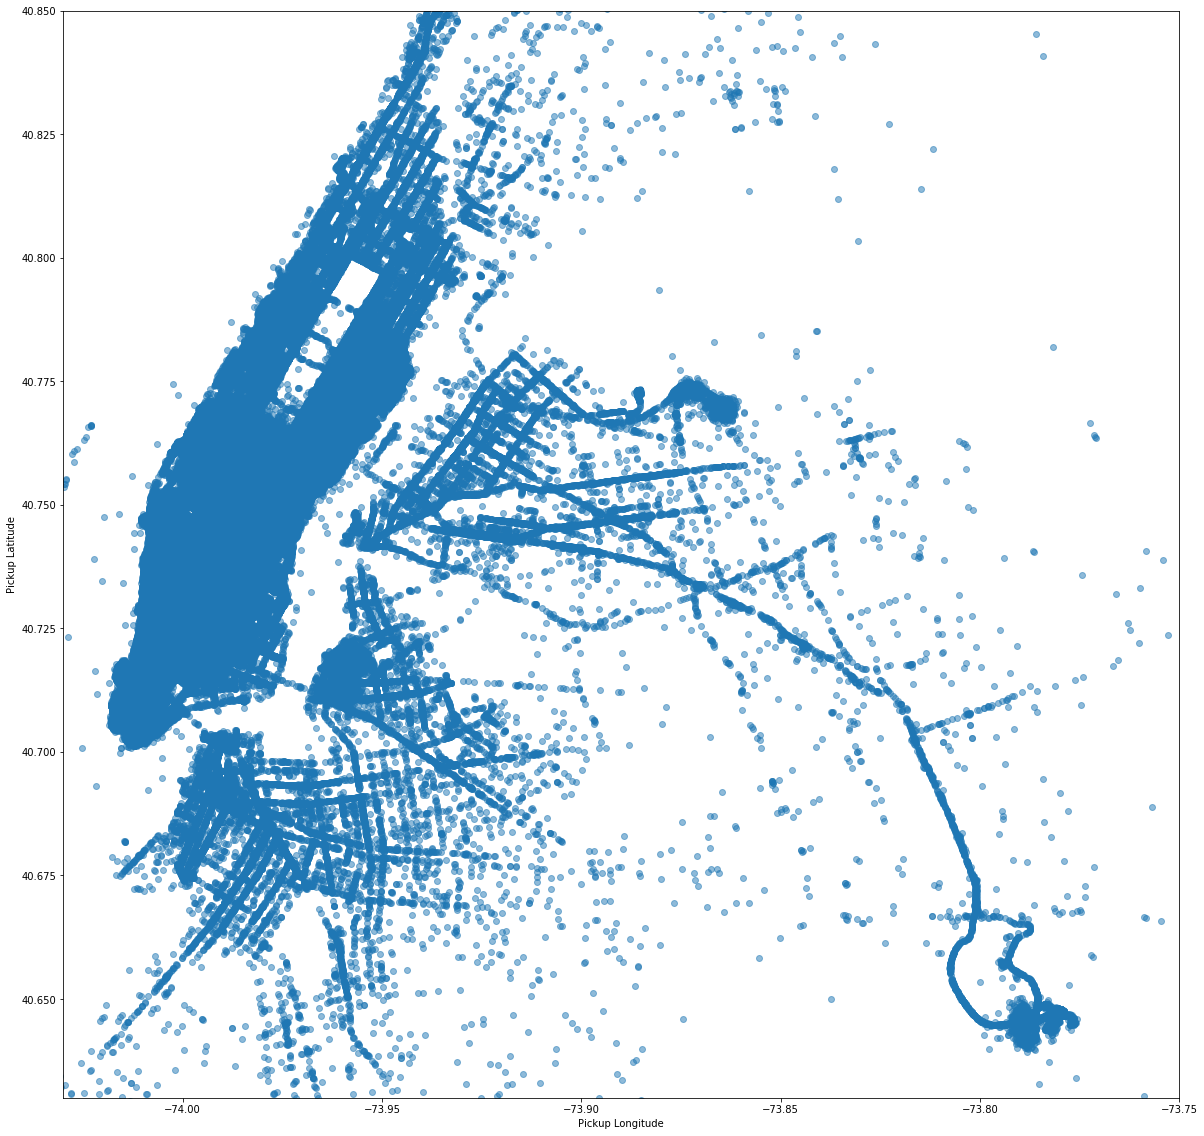

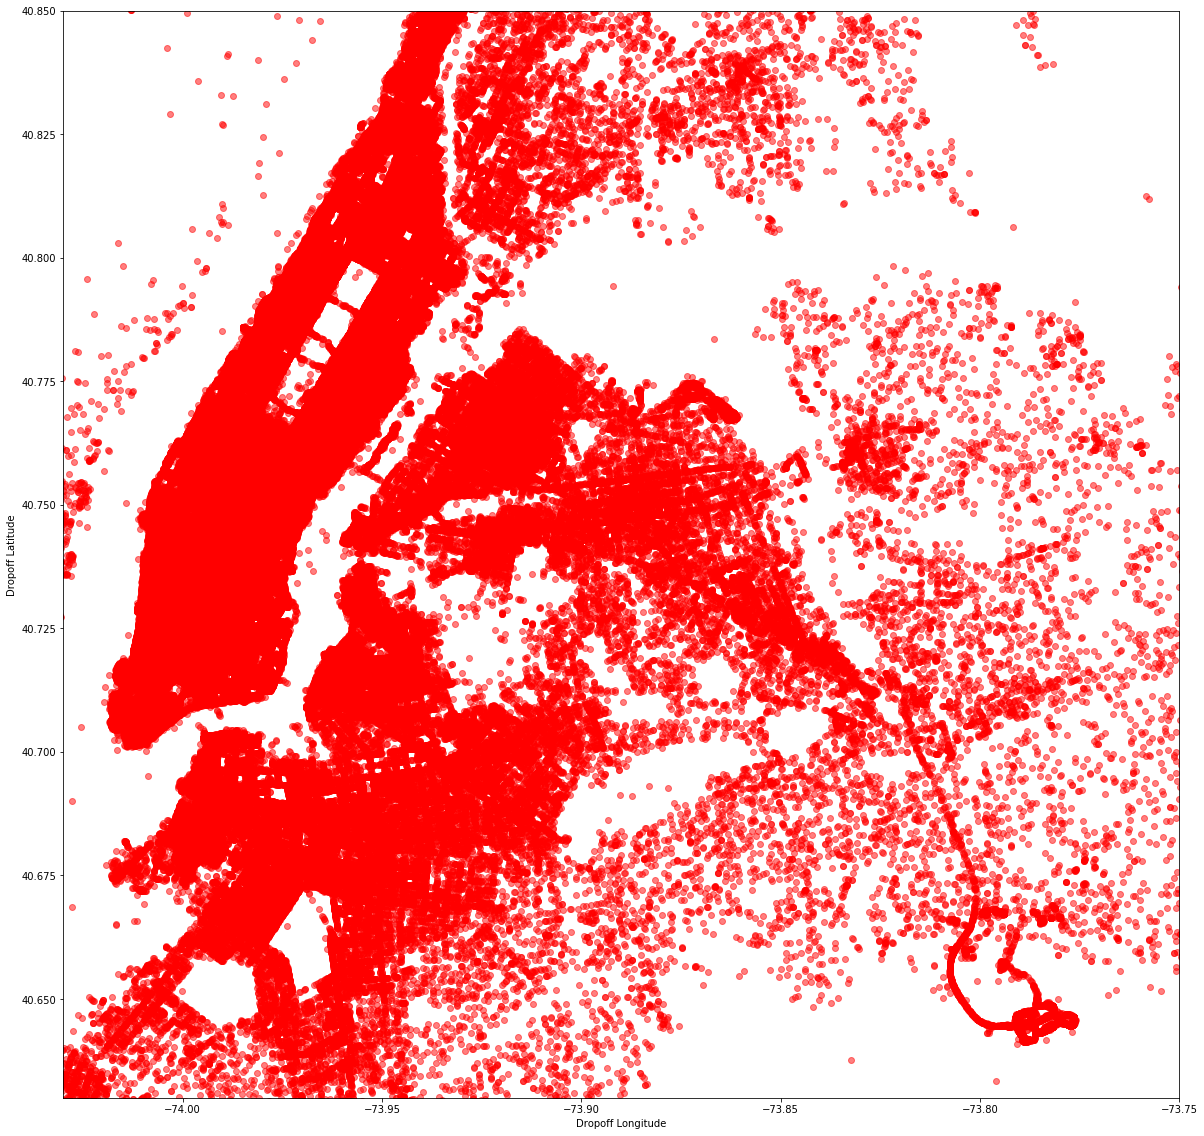

In [15]:
nyc_long_border = (-74.03, -73.75)
nyc_lat_border = (40.63, 40.85)

plt.figure(figsize=(20,20))
plt.scatter((train['pickup_longitude']), (train['pickup_latitude']), alpha=0.5)
plt.ylim(nyc_lat_border)
plt.xlim(nyc_long_border)
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')
plt.show

plt.figure(figsize=(20,20))
plt.scatter((train['dropoff_longitude']), (train['dropoff_latitude']), c='red', alpha=0.5)
plt.ylim(nyc_lat_border)
plt.xlim(nyc_long_border)
plt.xlabel('Dropoff Longitude')
plt.ylabel('Dropoff Latitude')
plt.show()

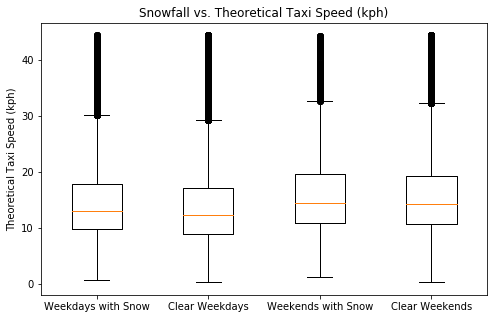

In [16]:
weather_summary = train[['theoretical_taxi_speed_kph', 'PRCP', 'SNOW', 'day_of_week']]
weather_summary['PRCP_FLAG'] = np.where(weather_summary['PRCP'] > 0.0, 'Y', 'N')
weather_summary['SNOW_FLAG'] = np.where(weather_summary['SNOW'] > 0.0, 'Y', 'N')

plt.figure(figsize=(8, 5))
plt.boxplot([weather_summary[(weather_summary['SNOW_FLAG'] == 'Y') & 
                             (weather_summary['day_of_week'].isin([0,1,2,3,4]))]['theoretical_taxi_speed_kph'],
            weather_summary[(weather_summary['PRCP_FLAG'] == 'N') & 
                            (weather_summary['SNOW_FLAG'] == 'N') &
                           (weather_summary['day_of_week'].isin([0,1,2,3,4]))]['theoretical_taxi_speed_kph'],
            
            weather_summary[(weather_summary['SNOW_FLAG'] == 'Y') & 
                             (weather_summary['day_of_week'].isin([5,6]))]['theoretical_taxi_speed_kph'],
            weather_summary[(weather_summary['PRCP_FLAG'] == 'N') & 
                            (weather_summary['SNOW_FLAG'] == 'N') &
                           (weather_summary['day_of_week'].isin([5,6]))]['theoretical_taxi_speed_kph']],
           labels = ['Weekdays with Snow', 'Clear Weekdays', 'Weekends with Snow', 'Clear Weekends'])
plt.title('Snowfall vs. Theoretical Taxi Speed (kph)')
plt.ylabel('Theoretical Taxi Speed (kph)')
plt.show()

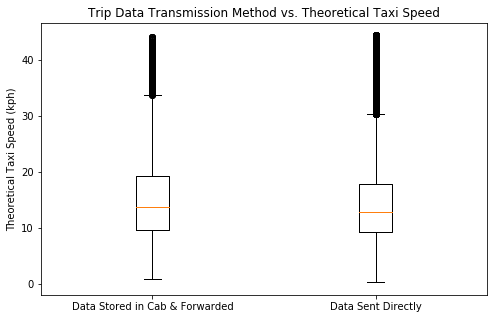

In [17]:
plt.figure(figsize=(8, 5))
plt.boxplot([train[train['store_and_fwd_flag'] == 1]['theoretical_taxi_speed_kph'].values,
            train[train['store_and_fwd_flag'] == 0]['theoretical_taxi_speed_kph'].values],
           labels = ['Data Stored in Cab & Forwarded', 'Data Sent Directly'])
plt.title('Trip Data Transmission Method vs. Theoretical Taxi Speed')
plt.ylabel('Theoretical Taxi Speed (kph)')
plt.show()

In [17]:
# Add new field that indicates if the duration is greater than median.
# We will use this for some stratified sampling later on.
train['greater_than_median_duration'] = np.where(train['trip_duration'] >= train['trip_duration'].median(),
                                             1,
                                             0)

def getStratifiedRandomTrainTestSets(df, colName, proportionOfOverall, testSize):
    
    if proportionOfOverall == 1:
        include_set = df
    else:
        split = StratifiedShuffleSplit(n_splits=1, test_size = proportionOfOverall, random_state=123)
        for exclude_index, include_index in split.split(df, df[colName]):
            exclude_set = df.loc[exclude_index]
            include_set = df.loc[include_index]
    
    include_set = include_set.reset_index(drop=True)
    split = StratifiedShuffleSplit(n_splits=1, test_size = testSize, random_state=123)
    for train_index, test_index in split.split(include_set, include_set[colName]):
        strat_train_set = include_set.loc[train_index]
        strat_test_set = include_set.loc[test_index]
    
    gc.collect()
        
    return strat_train_set, strat_test_set


categoricalColumns = ['month',
                      'date',
                      'day_of_week',
                      'hour_of_day',
                      'vendor_id',
                      'store_and_fwd_flag',
                      'JFK_Trip_Flag',
                      'LG_Trip_Flag']
    

numericalColumns = ['pickup_latitude',
                    'pickup_longitude',
                    'dropoff_latitude',
                    'dropoff_longitude',
                    'pickup_distance_from_mhtn',
                    'pickup_bearing_from_mhtn',
                    'dropoff_distance_from_mhtn',
                    'dropoff_bearing_from_mhtn',
                    'passenger_count',
                    'year',
                    'trip_distance',
                    'trip_init_bearing',
                     # Weather features
                    'PRCP', 'WT05', 'WT08', 'SNWD', 'WT09', 'WT11', 'SNOW', 'WT16', 'WT17', 'WT18', 'AWND', 'WT01',
                     # Shortest distance & traffic feats
                    'shortest_dist', 
                    'crossing', 'motorway_junction', 'stop', 'traffic_signals', 'turning_circle'
                   ]

targetVariableColumn = ['trip_duration']

## [3] Train Machine Learning Models

### [3.1] Define functions to prepare data for machine learning

In [18]:
# STEP 1A: build a pipeline for preprocessing the numerical attributes
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

# STEP 1B: combine both pipelines into a single one
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numericalColumns),
        ("cat_1", OneHotEncoder(categories=[[1,2,3,4,5,6,7,8,9,10,11,12]], sparse=False, handle_unknown = 'ignore'), ['month']),
        ("cat_2", OneHotEncoder(categories=[[0,1,2,3,4,5,6]], sparse=False, handle_unknown = 'ignore'), ['day_of_week']),
        ("cat_3", OneHotEncoder(categories=[[i for i in range(0, 25)]], sparse=False, handle_unknown = 'ignore'), ['hour_of_day']),
        ("cat_4", OneHotEncoder(categories=[[i for i in range(1, 32)]], sparse=False, handle_unknown = 'ignore'), ['date']),
        ("cat_5", OneHotEncoder(categories=[[1, 2]], sparse=False, handle_unknown = 'ignore'), ['vendor_id']),
        ("cat_6", OneHotEncoder(categories=[[0, 1]], sparse=False, handle_unknown = 'ignore'), ['store_and_fwd_flag']),
        ("cat_7", OneHotEncoder(categories=[[0, 1]], sparse=False, handle_unknown = 'ignore'), ['JFK_Trip_Flag']),
        ("cat_8", OneHotEncoder(categories=[[0, 1]], sparse=False, handle_unknown = 'ignore'), ['LG_Trip_Flag'])
    ])

    
def prepareDataForML(proportionOfOverall, 
                     testSize, 
                     categoricalColumns=categoricalColumns, 
                     numericalColumns=numericalColumns,
                     targetVariableColumn=targetVariableColumn,
                     df=train,
                     transform_pipe_line=full_pipeline):
    """
    A function that prepares the NYC taxi trip duration dataset for machine learning by applying the supplied data 
    transformation pipeline and randomly splitting into train and test sets using stratified sampling based on the
    'greater_than_median_duration' column. 
    
    Note: the function applies a log transformation on the target variable
    
    @param proportionOfOverall: the proportion of the overall dataset to use
    @param testSize: the ratio of test set size to train set size
    @param categoricalColumns: all categorical column names
    @param numericalColumns: all numerical Column names
    @param targetVariableColumn: the target variable column name
    @param df: the dataset to use
    @param transform_pipe_line: the data transformation pipeline
    
    """
    
    strat_train_set, strat_test_set = getStratifiedRandomTrainTestSets(df, 'greater_than_median_duration', proportionOfOverall, testSize)

    # STEP 2B: drop target values from training/test sets and copy to a new list
    X_Train = strat_train_set[categoricalColumns + numericalColumns]
    Y_Train = np.log1p(strat_train_set[targetVariableColumn[0]].copy())

    X_Test = strat_test_set[categoricalColumns + numericalColumns]
    Y_Test = np.log1p(strat_test_set[targetVariableColumn[0]].copy())

    # STEP 2E: prepare test and train feature sets
    X_Train_prepared = transform_pipe_line.fit_transform(X_Train)
    X_Test_prepared = transform_pipe_line.transform(X_Test)
    
    return X_Train_prepared, Y_Train, X_Test_prepared, Y_Test

### [3.2] Define functions to perform grid search & evaluate machine learning models

Here we define and initialize each of the 10 linear/ensemble regressors we plan to train along with the hyper-parameters to tune for each.
- <b>(1) OLS model  </b>


- <b>(2) Ridge regression model </b>

	- 'alpha': [0.1,0.5, 1.0]


- <b>(3) Lasso regression model </b>

	- 'alpha': [0.1,0.5, 1.0]


- <b>(4) Elastic Net model </b>

	- 'alpha': [0.1, 0.5, 1.0],
	- 'l1_ratio': [0.1, 0.5, 1]


- <b>(5) LARS Lasso </b>

	- 'alpha': [0.1,0.5, 1.0]


- <b>(6) Stochastic Gradient Descent </b>


- <b>(7) Support Vector Machine </b>

	- 'kernel' : ['rbf', 'linear', 'poly']


- <b>(8) Random forest regressor </b>

	- 'n_estimators': [10, 100, 200],
	- 'max_depth' : [3, 5, 10]


- <b>(9) AdaBoost Regressor </b>

	- 'learning_rate' : [0.01, 0.1, 0.5, 1], 


- <b>(10) GradientBoosted Regressor </b>

	- 'loss' : ['ls', 'lad', 'huber', 'quantile'],
	- 'learning_rate' : [0.01, 0.1, 0.5, 1], 
	- 'n_estimators': [10, 100, 200],
	- 'max_depth' : [1, 5, 10, 15]


In [12]:
def compute_rmse(y_true, y_pred): 
    """
    A function that computes the root mean squared error given actual and predicted values.
    
    @param y_true: the actual values
    @param y_pred: the predicted values
    """
    assert len(y_true) == len(y_pred)
    y_pred[y_pred < 0] = 0
    y_true[y_true < 0] = 0
    return np.sqrt(np.mean((y_pred - y_true)**2))

def performGridSearch(model, modelName, paramGrid, X_TRAIN_PREPARED, Y_TRAIN, useDefaultHyperParams = False):
    """
    A function that runs a GridSearchCV with 3-fold cross-validation on the supplied algorithm and tunes it using the 
    supplied hyper parameters. It then returns the results of the grid search.
    
    @param model: the regression model to fit
    @param modelName:  the name of the model
    @param paramGrid: the list of hyper parameters to evaluate the model on
    @param X_TRAIN_PREPARED: the feature set
    @param Y_TRAIN: the target variable to be predicted
    """
    if useDefaultHyperParams == True:
        paramGrid = {}
        
    grid_search = GridSearchCV(model, param_grid=paramGrid, cv=3, scoring= make_scorer(compute_rmse, 
                                                                                       greater_is_better=False))
    grid_search.fit(X_TRAIN_PREPARED, Y_TRAIN)
    return grid_search

# (1) OLS model
lm_param_grid = {}

# (2) Ride regression model
ridge_param_grid = {
    'alpha': [0.1,0.5, 1.0]
}

# (3) Lasso regression model
lasso_param_grid = {
    'alpha': [0.1,0.5, 1.0]
}

# (4) Elastic Net model
enet_param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'l1_ratio': [0.1, 0.5, 1]
}

# (5) LARS Lasso
larsLasso_param_grid = {
    'alpha': [0.1,0.5, 1.0]
}

# (6) Stochastic Gradient Descent
sgd_param_grid = {}

# (7) Support Vector Machine
svm_param_grid = {
    'kernel' : ['rbf', 'linear', 'poly']
}

# (8) Random forest regressor
rf_param_grid = {
    'n_estimators': [10, 100, 200],
    'max_depth' : [3, 5, 10]
}

# (9) AdaBoost Regressor
adbr_param_grid = {'n_estimators' : [10, 100, 200], 
                   'learning_rate' : [0.01, 0.1, 0.5, 1], 
}

# (10) GradientBoosted Regressor
gbr_param_grid = {
    'loss' : ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate' : [0.01, 0.1, 0.5, 1], 
    'n_estimators': [10, 100, 200],
    'max_depth' : [1, 5, 10, 15]
}

listOfModelsToEvaluate = {'SimpleOLS': (linear_model.LinearRegression(), lm_param_grid),
                          'Ridge': (linear_model.Ridge(random_state = 42), ridge_param_grid),
                          'Lasso': (linear_model.Lasso(random_state = 42), lasso_param_grid),
                          'ElasticNet': (linear_model.ElasticNet(random_state = 42), enet_param_grid),
                          'LARSLasso': (linear_model.LassoLars(), larsLasso_param_grid),
                          'SGD': (linear_model.SGDRegressor(max_iter=1000, tol=1e-3), sgd_param_grid),
                          'LinearSVR': (LinearSVR(), svm_param_grid),
                          'RandomForest': (RandomForestRegressor(random_state=42), rf_param_grid),
                          'AdaBoost': (AdaBoostRegressor(random_state=42), adbr_param_grid),
                          'GradientBoost': (GradientBoostingRegressor(random_state=42), gbr_param_grid)
                         }

resultsSummary = pd.DataFrame(columns=['Iteration_Num', 'Model_Name', 'Avg_CV_RMSLE', 'Avg_Fit_Time', 'Avg_Train_RMSLE', 
                                       'Best_CV_RMSLE', 'Validation_RMSLE', 'Winning_Hyper_Params'])

# Keeps track of the iteration id
iteration_counter = 0
# Proportion of overall dataset to use in the model fit exercise
proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# Keeps track of the model id
model_counter = 0
# Get a copy of the list of models to evaluate
listOfModelsToEvaluate_copy = listOfModelsToEvaluate.copy()

### [3.3] Select Top 3 models from our list of 10

We will use the following strategy:

- In increments of 10%, perform a grid search with 3-fold cross-validation on each of the 10 regressors along with the supplied list of hyper-parameters
- At the end of each iteration, discard the worst performing model (based on highest RMSLE score)
- Continue until we are left with only 3 models

<b>Results</b>:<br>
We find that the following models were our Top 3 performers:
- Best model: Random Forest Regressor
- Position 2: Gradient Boosted Regressor
- Position 3: Oridinary Least Squares Regressor

In [22]:
for proportion in proportions:
    iteration_counter = iteration_counter + 1
    
    # Get test train sets
    X_Train_prepared, Y_Train, X_Test_prepared, Y_Test = prepareDataForML(df=train, proportionOfOverall=proportion, testSize=0.2)
    logger.info('Iteration no.['+ str(iteration_counter) + ']. Dataset proportion of overall: [' + str(proportion) + ']')
    
    for key, value in listOfModelsToEvaluate_copy.items():
        model_counter = model_counter + 1
        logger.info('Doing model: [' + str(model_counter) + ' of ' + str(len(listOfModelsToEvaluate_copy)) +' ]: '+ key)
        tune_results = performGridSearch(model=value[0], 
                         modelName=key,
                         paramGrid=value[1],
                         X_TRAIN_PREPARED=X_Train_prepared, 
                         Y_TRAIN=Y_Train,
                         useDefaultHyperParams = True)

        nextModelResult = { 'Iteration_Num': iteration_counter,
                            'Model_Name': key,
                            'Avg_Train_RMSLE' : (-(tune_results.cv_results_['mean_train_score'].mean())),
                            'Avg_CV_RMSLE' : (-(tune_results.cv_results_['mean_test_score'].mean())),
                            'Best_CV_RMSLE' : (-(tune_results.best_score_)),
                             # Evaluate on validation set
                            'Validation_RMSLE' : -(tune_results.score(X=X_Test_prepared, y=Y_Test)),
                            'Winning_Hyper_Params': tune_results.best_params_,
                            'Avg_Fit_Time' : (tune_results.cv_results_['mean_fit_time'].mean())
                          }
        resultsSummary = resultsSummary.append(nextModelResult, ignore_index=True)
        logger.info(nextModelResult)
        
        # If we are at the final iteration, write the top 3 models to disk as pickle files for use later
        if iteration_counter == len(proportions):
            logger.info('==> Writing model to disk since we are in the final iteration')
            filehandler = open('models_with_traffic_feats/' + key+".obj","wb")
            pickle.dump(tune_results.best_estimator_,filehandler)
            filehandler.close()
        logger.info('...Done!')
    
    # Find the model that performed the worst and remove from list if we are left
    # with more than 3 models
    if len(listOfModelsToEvaluate_copy) > 3:
        modelToRemove = resultsSummary[resultsSummary['Iteration_Num'] == 
                                           iteration_counter].sort_values(by='Avg_CV_RMSLE').tail(1)['Model_Name'].values[0]
        logger.info(modelToRemove + ' had the worst RMSE in this round - removing from list!')
        del listOfModelsToEvaluate_copy[modelToRemove]
        
    model_counter = 0

# Write to a file for later use - we may not want to re-run this given the amount
# of time it takes.
resultsSummary.to_csv('resultsSummary_WITH_TRAFFIC_FEATS.csv', index=False)

2018-12-10 21:23:04,112 [3253_TermProjv2] INFO     Iteration no.[1]. Dataset proportion of overall: [0.1]
2018-12-10 21:23:04,112 [3253_TermProjv2] INFO     Doing model: [1 of 10 ]: LinearSVR
2018-12-10 21:24:36,153 [3253_TermProjv2] INFO     {'Avg_Fit_Time': 20.24080268541972, 'Iteration_Num': 1, 'Avg_CV_RMSLE': 0.44092188348947631, 'Model_Name': 'LinearSVR', 'Winning_Hyper_Params': {}, 'Validation_RMSLE': 0.43734906887939456, 'Avg_Train_RMSLE': 0.44045047556831762, 'Best_CV_RMSLE': 0.44092188348947631}
2018-12-10 21:24:36,153 [3253_TermProjv2] INFO     ...Done!
2018-12-10 21:24:36,153 [3253_TermProjv2] INFO     Doing model: [2 of 10 ]: LARSLasso
2018-12-10 21:24:37,155 [3253_TermProjv2] INFO     {'Avg_Fit_Time': 0.20404481887817383, 'Iteration_Num': 1, 'Avg_CV_RMSLE': 0.68821589194218946, 'Model_Name': 'LARSLasso', 'Winning_Hyper_Params': {}, 'Validation_RMSLE': 0.6839167042241312, 'Avg_Train_RMSLE': 0.68819153169143787, 'Best_CV_RMSLE': 0.68821589194218946}
2018-12-10 21:24:37,155 [

2018-12-10 21:42:09,094 [3253_TermProjv2] INFO     Doing model: [8 of 9 ]: SGD
2018-12-10 21:42:12,002 [3253_TermProjv2] INFO     {'Avg_Fit_Time': 0.63626670837402344, 'Iteration_Num': 2, 'Avg_CV_RMSLE': 0.437301892551756, 'Model_Name': 'SGD', 'Winning_Hyper_Params': {}, 'Validation_RMSLE': 0.43916386718270078, 'Avg_Train_RMSLE': 0.43701605122075809, 'Best_CV_RMSLE': 0.437301892551756}
2018-12-10 21:42:12,002 [3253_TermProjv2] INFO     ...Done!
2018-12-10 21:42:12,002 [3253_TermProjv2] INFO     Doing model: [9 of 9 ]: GradientBoost
2018-12-10 21:49:50,484 [3253_TermProjv2] INFO     {'Avg_Fit_Time': 99.341066757837936, 'Iteration_Num': 2, 'Avg_CV_RMSLE': 0.34782830756625382, 'Model_Name': 'GradientBoost', 'Winning_Hyper_Params': {}, 'Validation_RMSLE': 0.34969277156448053, 'Avg_Train_RMSLE': 0.34601158246391611, 'Best_CV_RMSLE': 0.34782830756625382}
2018-12-10 21:49:50,484 [3253_TermProjv2] INFO     ...Done!
2018-12-10 21:49:50,484 [3253_TermProjv2] INFO     ElasticNet had the worst RMS

2018-12-10 23:02:38,199 [3253_TermProjv2] INFO     ...Done!
2018-12-10 23:02:38,199 [3253_TermProjv2] INFO     AdaBoost had the worst RMSE in this round - removing from list!
2018-12-10 23:02:44,917 [3253_TermProjv2] INFO     Iteration no.[5]. Dataset proportion of overall: [0.5]
2018-12-10 23:02:44,917 [3253_TermProjv2] INFO     Doing model: [1 of 6 ]: LinearSVR
2018-12-10 23:11:31,837 [3253_TermProjv2] INFO     {'Avg_Fit_Time': 115.57869100570679, 'Iteration_Num': 5, 'Avg_CV_RMSLE': 0.43960869560591742, 'Model_Name': 'LinearSVR', 'Winning_Hyper_Params': {}, 'Validation_RMSLE': 0.44234740757770408, 'Avg_Train_RMSLE': 0.43950469819850913, 'Best_CV_RMSLE': 0.43960869560591742}
2018-12-10 23:11:31,837 [3253_TermProjv2] INFO     ...Done!
2018-12-10 23:11:31,837 [3253_TermProjv2] INFO     Doing model: [2 of 6 ]: RandomForest
2018-12-10 23:22:06,559 [3253_TermProjv2] INFO     {'Avg_Fit_Time': 133.77631258964539, 'Iteration_Num': 5, 'Avg_CV_RMSLE': 0.32702627358268843, 'Model_Name': 'RandomF

2018-12-11 01:32:11,924 [3253_TermProjv2] INFO     ...Done!
2018-12-11 01:32:11,924 [3253_TermProjv2] INFO     Doing model: [2 of 3 ]: Ridge
2018-12-11 01:32:18,693 [3253_TermProjv2] INFO     {'Avg_Fit_Time': 1.4033912022908528, 'Iteration_Num': 8, 'Avg_CV_RMSLE': 0.43633937283971014, 'Model_Name': 'Ridge', 'Winning_Hyper_Params': {}, 'Validation_RMSLE': 0.43769201677373432, 'Avg_Train_RMSLE': 0.43627015708902223, 'Best_CV_RMSLE': 0.43633937283971014}
2018-12-11 01:32:18,693 [3253_TermProjv2] INFO     ...Done!
2018-12-11 01:32:18,693 [3253_TermProjv2] INFO     Doing model: [3 of 3 ]: GradientBoost
2018-12-11 02:09:08,535 [3253_TermProjv2] INFO     {'Avg_Fit_Time': 481.25981322924298, 'Iteration_Num': 8, 'Avg_CV_RMSLE': 0.34809720821160084, 'Model_Name': 'GradientBoost', 'Winning_Hyper_Params': {}, 'Validation_RMSLE': 0.34906644771640249, 'Avg_Train_RMSLE': 0.34755713089831475, 'Best_CV_RMSLE': 0.34809720821160084}
2018-12-11 02:09:08,535 [3253_TermProjv2] INFO     ...Done!
2018-12-11 0

In [72]:
if len(resultsSummary) <= 0:
    resultsSummary = pd.read_csv('resultsSummary.csv')
    
winning_models = (resultsSummary[resultsSummary['Iteration_Num'] == resultsSummary['Iteration_Num'].max()]['Model_Name'].values)

winning_models = (resultsSummary[resultsSummary['Iteration_Num'] == resultsSummary['Iteration_Num'].max()]['Model_Name'].values)

# The models that didn't make it
discarded_models_df = resultsSummary[~(resultsSummary['Model_Name'].isin(winning_models))]
discarded_models = discarded_models_df['Model_Name'].unique()

# Plot Discarded Models Summary
all_dm_traces = []
for model in discarded_models:
    model_trace = go.Scatter(x = discarded_models_df[discarded_models_df['Model_Name'] == model]['Iteration_Num'].apply(lambda x: (proportions[x - 1] * 100)),
                             y = discarded_models_df[discarded_models_df['Model_Name'] == model]['Avg_CV_RMSLE'],
                             name = model)
    all_dm_traces = all_dm_traces + [model_trace]

# Plot Winning Models Summary
all_wm_traces = []
for model in winning_models:
    model_trace = go.Scatter(x = resultsSummary[resultsSummary['Model_Name'] == model]['Iteration_Num'].apply(lambda x: (proportions[x - 1] * 100)),
                             y = resultsSummary[resultsSummary['Model_Name'] == model]['Avg_CV_RMSLE'],
                             name = model)
    all_wm_traces = all_wm_traces + [model_trace]

layout = go.Layout(
    title='<b>All Models: Train Data Proportion vs. Root Mean Squared Logarithmic Error (RMSLE)</b>',
    yaxis=dict(
        zeroline=False,
        title='<b>Cross-Validated RMSLE</b>'
    ),
    xaxis=dict(
        title='<b>Proportion of Data Used in Training (%)</b>'
    )
)
fig = go.Figure(data=all_dm_traces + all_wm_traces, layout=layout)
iplot(fig)

In [13]:
if len(resultsSummary) <= 0:
    resultsSummary = pd.read_csv('resultsSummary_WITH_TRAFFIC_FEATS.csv')
    
winning_models = (resultsSummary[resultsSummary['Iteration_Num'] == resultsSummary['Iteration_Num'].max()]['Model_Name'].values)

winning_models = (resultsSummary[resultsSummary['Iteration_Num'] == resultsSummary['Iteration_Num'].max()]['Model_Name'].values)

# The models that didn't make it
discarded_models_df = resultsSummary[~(resultsSummary['Model_Name'].isin(winning_models))]
discarded_models = discarded_models_df['Model_Name'].unique()

# Plot Discarded Models Summary
all_dm_traces = []
for model in discarded_models:
    model_trace = go.Scatter(x = discarded_models_df[discarded_models_df['Model_Name'] == model]['Iteration_Num'].apply(lambda x: (proportions[x - 1] * 100)),
                             y = discarded_models_df[discarded_models_df['Model_Name'] == model]['Avg_CV_RMSLE'],
                             name = model)
    all_dm_traces = all_dm_traces + [model_trace]

# Plot Winning Models Summary
all_wm_traces = []
for model in winning_models:
    model_trace = go.Scatter(x = resultsSummary[resultsSummary['Model_Name'] == model]['Iteration_Num'].apply(lambda x: (proportions[x - 1] * 100)),
                             y = resultsSummary[resultsSummary['Model_Name'] == model]['Avg_CV_RMSLE'],
                             name = model)
    all_wm_traces = all_wm_traces + [model_trace]

layout = go.Layout(
    title='<b>All Models: Train Data Proportion vs. Root Mean Squared Logarithmic Error (RMSLE)</b>',
    yaxis=dict(
        zeroline=False,
        title='<b>Cross-Validated RMSLE</b>'
    ),
    xaxis=dict(
        title='<b>Proportion of Data Used in Training (%)</b>'
    )
)
fig = go.Figure(data=all_dm_traces + all_wm_traces, layout=layout)
iplot(fig)

### [3.4]: Run predictions using our Top 3 models on both the dataset for the competition as well as a validation set from our training data

We make the following observations from the plot of residuals below:

- The RandomForest model displays a fair bit of heteroskedasticity: it tends to under-predict lower values but does better as values increase

- The Gradient Boosted regressor seems to consistently under-predict

- The OLS model has the widest error margins

In [89]:
# Read in the winning models from disk and make predictions to submit
df_forSubmission_X = full_pipeline.fit_transform(test)
submit_df = test[['id']]

# Also predict on our validation set to get an idea of the residuals
validation_df = pd.DataFrame(columns=['actual_trip_duration'])
validation_df['actual_trip_duration']  = Y_Test.tolist()
validation_df['actual_trip_duration'] = validation_df['actual_trip_duration'].apply(lambda x: np.exp(x))

for model_name in winning_models:
    logger.info('Reading model: '+model_name + ' from disk...')
    model = pickle.load(open(model_name+'.obj', 'rb' ))
    
    # Make predictions on submission set
    logger.info('Running predictions on submission set...')
    predictions = model.predict(X = df_forSubmission_X)
    # Add to the submission DF
    submit_df[model_name+'_pred'] = predictions.tolist()
    submit_df[model_name+'_pred'] = (np.exp(submit_df[model_name+'_pred']))   
    
    # Make predictions on validation set
    logger.info('Running predictions on validation set...')
    predictions = model.predict(X = X_Test_prepared)
    # Add to the validation DF
    validation_df[model_name+'_pred'] = predictions.tolist()
    validation_df[model_name+'_pred'] = np.exp(validation_df[model_name+'_pred'])
    logger.info('...done.')

2018-12-03 16:34:21,007 [3253_TermProjv2] INFO     Reading model: GradientBoost from disk...
2018-12-03 16:34:21,012 [3253_TermProjv2] INFO     Running predictions on submission set...
2018-12-03 16:34:23,508 [3253_TermProjv2] INFO     Running predictions on validation set...
2018-12-03 16:34:25,242 [3253_TermProjv2] INFO     ...done.
2018-12-03 16:34:25,244 [3253_TermProjv2] INFO     Reading model: RandomForest from disk...
2018-12-03 16:34:27,028 [3253_TermProjv2] INFO     Running predictions on submission set...
2018-12-03 16:34:31,143 [3253_TermProjv2] INFO     Running predictions on validation set...
2018-12-03 16:34:34,688 [3253_TermProjv2] INFO     ...done.
2018-12-03 16:34:34,690 [3253_TermProjv2] INFO     Reading model: SimpleOLS from disk...
2018-12-03 16:34:34,785 [3253_TermProjv2] INFO     Running predictions on submission set...
2018-12-03 16:34:35,044 [3253_TermProjv2] INFO     Running predictions on validation set...
2018-12-03 16:34:35,197 [3253_TermProjv2] INFO     ...

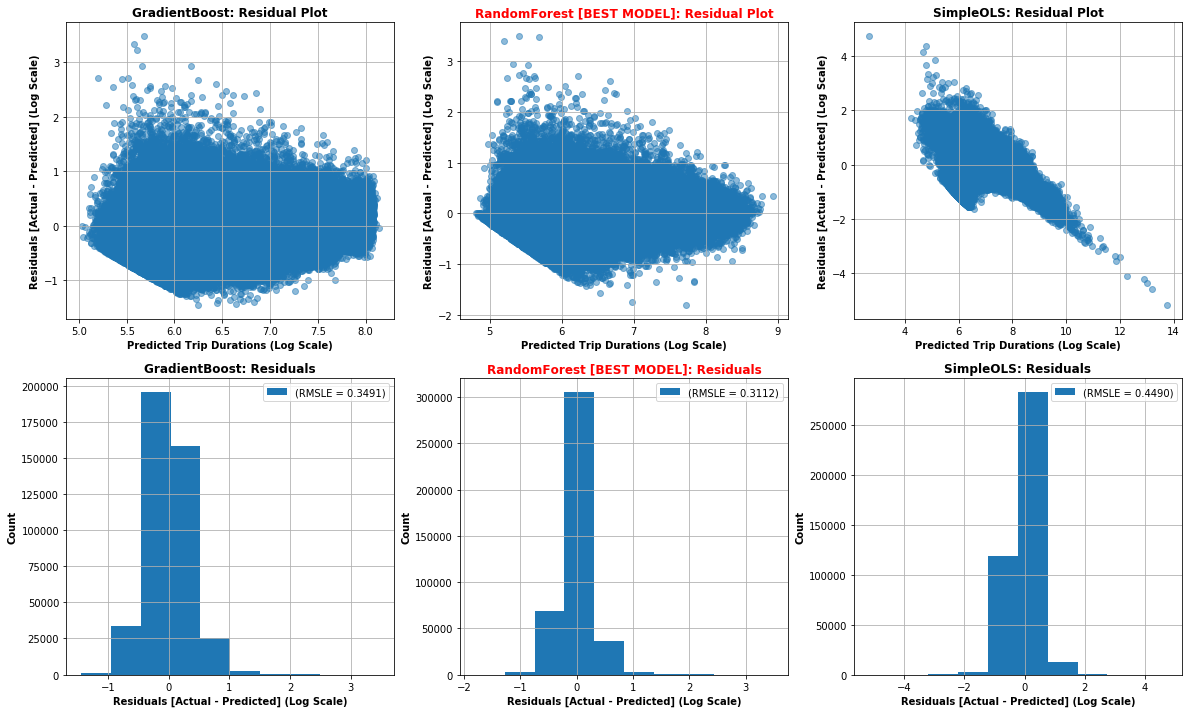

In [90]:
fig = plt.figure(figsize=(20, 12))

final_iter_num = resultsSummary['Iteration_Num'].max()
best_rmsle = resultsSummary[resultsSummary['Iteration_Num'] == final_iter_num]['Best_CV_RMSLE'].min()

best_models = resultsSummary[(resultsSummary['Iteration_Num'] == final_iter_num) & 
                             (resultsSummary['Best_CV_RMSLE'] == best_rmsle)]['Model_Name'].values

plot_counter = 0
for model_name in winning_models:
    color = 'black'
    title_prefix = model_name
    
    if model_name in best_models:
        color = 'red'
        title_prefix += ' [BEST MODEL]'
            
    plot_counter += 1
    ax = plt.subplot(2,3,plot_counter)
    ax.scatter(np.log(validation_df[model_name + '_pred']),
              (np.log(validation_df['actual_trip_duration']) - np.log(validation_df[model_name + '_pred'])),
               alpha=0.5)
    ax.set_title(title_prefix + ': Residual Plot', color=color, weight= 'bold')
    ax.set_xlabel('Predicted Trip Durations (Log Scale)', weight= 'bold')
    ax.set_ylabel('Residuals [Actual - Predicted] (Log Scale)', weight= 'bold')
    ax.grid()

    # Find the final validation RMSLE
    rmsle = resultsSummary[(resultsSummary['Iteration_Num'] == final_iter_num) &
                                      (resultsSummary['Model_Name'] == model_name)]['Validation_RMSLE']
    
    ax = plt.subplot(2,3,(plot_counter + 3))
    ax.hist((np.log(validation_df['actual_trip_duration']) - np.log(validation_df[model_name+'_pred'])),
           label='(RMSLE = %0.4f)' % (rmsle))
    ax.set_title(title_prefix + ': Residuals', color=color, weight= 'bold')
    ax.set_ylabel('Count', weight= 'bold')
    ax.set_xlabel('Residuals [Actual - Predicted] (Log Scale)', weight= 'bold')
    ax.legend()
    ax.grid()

In [58]:
submit_df_Final = submit_df[['id', 'RandomForest_pred']].rename(columns={'RandomForest_pred':'trip_duration'})
submit_df_Final.to_csv('RF_Test_submit_100pct_NEW_FEAT_01DEC.csv', index=False)

submit_df_Final = submit_df[['id', 'GradientBoost_pred']].rename(columns={'GradientBoost_pred':'trip_duration'})
submit_df_Final.to_csv('GB_Test_submit_100pct_NEW_FEAT_01DEC.csv', index=False)


In [37]:
# Read in the winning models from disk and make predictions to submit
df_forSubmission_X = full_pipeline.fit_transform(test)
submit_df = test[['id']]

# Also predict on our validation set to get an idea of the residuals
validation_df = pd.DataFrame(columns=['actual_trip_duration'])
validation_df['actual_trip_duration']  = Y_Test.tolist()
validation_df['actual_trip_duration'] = validation_df['actual_trip_duration'].apply(lambda x: np.exp(x))

for model_name in winning_models:
    logger.info('Reading model: '+model_name + ' from disk...')
    model = pickle.load(open('models_with_traffic_feats/' + model_name+'.obj', 'rb' ))
    
    # Make predictions on submission set
    logger.info('Running predictions on submission set...')
    predictions = model.predict(X = df_forSubmission_X)
    # Add to the submission DF
    submit_df[model_name+'_pred'] = predictions.tolist()
    submit_df[model_name+'_pred'] = (np.exp(submit_df[model_name+'_pred']))   
    
    # Make predictions on validation set
    logger.info('Running predictions on validation set...')
    predictions = model.predict(X = X_Test_prepared)
    # Add to the validation DF
    validation_df[model_name+'_pred'] = predictions.tolist()
    validation_df[model_name+'_pred'] = np.exp(validation_df[model_name+'_pred'])
    logger.info('...done.')

2018-12-11 15:22:35,333 [3253_TermProjv2] INFO     Reading model: RandomForest from disk...
2018-12-11 15:22:37,435 [3253_TermProjv2] INFO     Running predictions on submission set...
2018-12-11 15:22:41,998 [3253_TermProjv2] INFO     Running predictions on validation set...
2018-12-11 15:22:45,587 [3253_TermProjv2] INFO     ...done.
2018-12-11 15:22:45,587 [3253_TermProjv2] INFO     Reading model: Ridge from disk...
2018-12-11 15:22:45,638 [3253_TermProjv2] INFO     Running predictions on submission set...
2018-12-11 15:22:45,968 [3253_TermProjv2] INFO     Running predictions on validation set...
2018-12-11 15:22:46,141 [3253_TermProjv2] INFO     ...done.
2018-12-11 15:22:46,141 [3253_TermProjv2] INFO     Reading model: GradientBoost from disk...
2018-12-11 15:22:46,141 [3253_TermProjv2] INFO     Running predictions on submission set...
2018-12-11 15:22:48,986 [3253_TermProjv2] INFO     Running predictions on validation set...
2018-12-11 15:22:50,888 [3253_TermProjv2] INFO     ...done

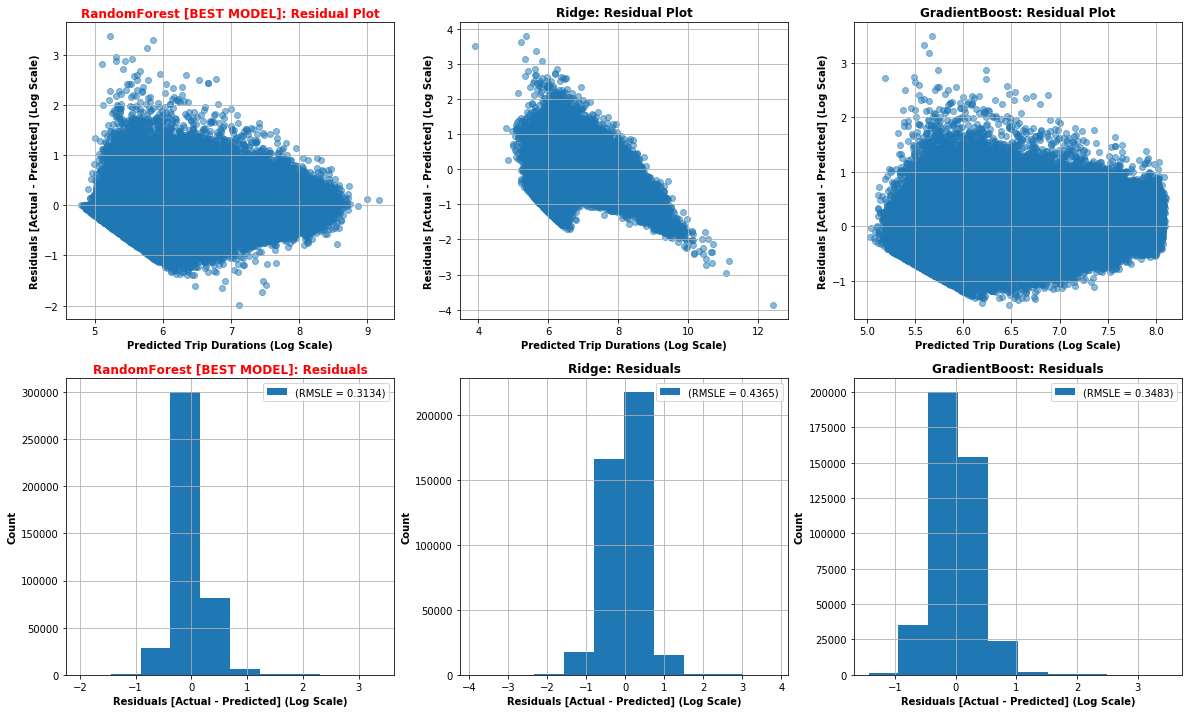

In [22]:
fig = plt.figure(figsize=(20, 12))

final_iter_num = resultsSummary['Iteration_Num'].max()
best_rmsle = resultsSummary[resultsSummary['Iteration_Num'] == final_iter_num]['Best_CV_RMSLE'].min()

best_models = resultsSummary[(resultsSummary['Iteration_Num'] == final_iter_num) & 
                             (resultsSummary['Best_CV_RMSLE'] == best_rmsle)]['Model_Name'].values

plot_counter = 0
for model_name in winning_models:
    color = 'black'
    title_prefix = model_name
    
    if model_name in best_models:
        color = 'red'
        title_prefix += ' [BEST MODEL]'
            
    plot_counter += 1
    ax = plt.subplot(2,3,plot_counter)
    ax.scatter(np.log(validation_df[model_name + '_pred']),
              (np.log(validation_df['actual_trip_duration']) - np.log(validation_df[model_name + '_pred'])),
               alpha=0.5)
    ax.set_title(title_prefix + ': Residual Plot', color=color, weight= 'bold')
    ax.set_xlabel('Predicted Trip Durations (Log Scale)', weight= 'bold')
    ax.set_ylabel('Residuals [Actual - Predicted] (Log Scale)', weight= 'bold')
    ax.grid()

    # Find the final validation RMSLE
    rmsle = resultsSummary[(resultsSummary['Iteration_Num'] == final_iter_num) &
                                      (resultsSummary['Model_Name'] == model_name)]['Validation_RMSLE']
    
    ax = plt.subplot(2,3,(plot_counter + 3))
    ax.hist((np.log(validation_df['actual_trip_duration']) - np.log(validation_df[model_name+'_pred'])),
           label='(RMSLE = %0.4f)' % (rmsle))
    ax.set_title(title_prefix + ': Residuals', color=color, weight= 'bold')
    ax.set_ylabel('Count', weight= 'bold')
    ax.set_xlabel('Residuals [Actual - Predicted] (Log Scale)', weight= 'bold')
    ax.legend()
    ax.grid()

In [39]:
submit_df_Final = submit_df[['id', 'RandomForest_pred']].rename(columns={'RandomForest_pred':'trip_duration'})
submit_df_Final.to_csv('models_with_traffic_feats/RF_Test_submit_100pct_OSM_FEAT.csv', index=False)

submit_df_Final = submit_df[['id', 'GradientBoost_pred']].rename(columns={'GradientBoost_pred':'trip_duration'})
submit_df_Final.to_csv('models_with_traffic_feats/GB_Test_submit_100pct_OSM_FEAT.csv', index=False)

submit_df['RF_GB_AVG_pred'] = (submit_df['RandomForest_pred'] + submit_df['GradientBoost_pred'])/2

submit_df['RF_GB_RDG_AVG_pred'] = (submit_df['RandomForest_pred'] + submit_df['GradientBoost_pred'] + submit_df['Ridge_pred'])/3

submit_df_Final = submit_df[['id', 'RF_GB_RDG_AVG_pred']].rename(columns={'RF_GB_RDG_AVG_pred':'trip_duration'})
submit_df_Final.to_csv('models_with_traffic_feats/GB_RF_RDG_AVG_Test_submit_100pct_OSM_FEAT.csv', index=False)


In [44]:
compute_rmse(y_pred=np.log((validation_df['RandomForest_pred'] + validation_df['GradientBoost_pred'])/2),
             y_true=np.log(validation_df['actual_trip_duration']))

0.28981588693961996

### [3.5] Examine feature importances from each of the Top 3 models

The <b>RandomForest</b> model indicates that the following are the Top 6 important features in terms of predicting trip duration:

- <b>trip_distance:</b> the great-circle distance between start/end points of each trip
- <b>trip_init_bearing:</b> the bearing between trip start/end points
- <b>dropoff_latitude:</b> the latitude coordinate of the destination
- <b>pickup_/dropoff_bearing_from_mhtn:</b> the bearing between pickup/dropoff locations and city centre
- <b>dropoff_distance_from_mhtn</b>: the distance between dropoff location and city centre


The <b>Gradient Boosted Regression</b> model indicates that the following are the Top 6 important features in terms of predicting trip duration:

- <b>trip_distance:</b> the great-circle distance between start/end points of each trip
- <b>trip_init_bearing:</b> the bearing between trip start/end points
- <b>dropoff_latitude:</b> the latitude coordinate of the destination
- <b>day_of_week_6:</b> day of week == Sunday
- <b>hour_of_day_6:</b> trip starts between 6AM and 7AM
- <b>pickup_bearing_from_mhtn:</b> the bearing between pickup location and city centre

In [56]:
feat_names = (numericalColumns + 
             ['month_' + str(x) for x in [1,2,3,4,5,6,7,8,9,10,11,12]] +
             ['day_of_week_' + str(x) for x in [0,1,2,3,4,5,6]] +
             ['hour_of_day_' + str(x) for x in [i for i in range(0, 25)]] +
             ['date_' + str(x) for x in [i for i in range(1, 32)]] +
             ['vendor_id_' + str(x) for x in [1, 2]] +
             ['store_and_fwd_flag_' + str(x) for x in [0, 1]] +
             ['JFK_Trip_Flag_' + str(x) for x in [0, 1]] +
             ['LG_Trip_Flag_' + str(x) for x in [0, 1]])

# RandomForest Feature Importances
rf_model = pickle.load(open('RandomForest.obj', 'rb' ))
rf_feat_importances = pd.DataFrame(list(zip(feat_names, rf_model.feature_importances_)), columns=['feat_name', 'importance'])
rf_feat_importances = rf_feat_importances.sort_values(by='importance', ascending=False)
rf_feat_importances[:10]

,feat_name,importance
10,trip_distance,0.657633
11,trip_init_bearing,0.049147
2,dropoff_latitude,0.025158
5,pickup_bearing_from_mhtn,0.024300
7,dropoff_bearing_from_mhtn,0.019952
6,dropoff_distance_from_mhtn,0.019538
3,dropoff_longitude,0.018074
1,pickup_longitude,0.016761
0,pickup_latitude,0.015266
4,pickup_distance_from_mhtn,0.014594


In [57]:
# GradientBoost Feature Importances
gb_model = pickle.load(open('GradientBoost.obj', 'rb' ))
gb_feat_importances = pd.DataFrame(list(zip(feat_names, gb_model.feature_importances_)), columns=['feat_name', 'importance'])
gb_feat_importances = gb_feat_importances.sort_values(by='importance', ascending=False)
gb_feat_importances[:10]

,feat_name,importance
10,trip_distance,0.863824
11,trip_init_bearing,0.034677
2,dropoff_latitude,0.019343
42,day_of_week_6,0.009309
49,hour_of_day_6,0.008476
5,pickup_bearing_from_mhtn,0.005134
6,dropoff_distance_from_mhtn,0.004941
48,hour_of_day_5,0.004672
41,day_of_week_5,0.004271
1,pickup_longitude,0.003784


In [58]:
ols_model = pickle.load(open('SimpleOLS.obj', 'rb' ))
ols_feat_importances = pd.DataFrame(list(zip(feat_names, ols_model.coef_)), columns=['feat_name', 'coeff'])
ols_feat_importances['abs_coeff'] = np.abs(ols_feat_importances['coeff'])
ols_feat_importances = ols_feat_importances.sort_values(by='abs_coeff', ascending=False)
ols_feat_importances

,feat_name,coeff,abs_coeff
9,year,7.846969e+11,7.846969e+11
39,day_of_week_3,3.211352e+11,3.211352e+11
38,day_of_week_2,3.211352e+11,3.211352e+11
40,day_of_week_4,3.211352e+11,3.211352e+11
37,day_of_week_1,3.211352e+11,3.211352e+11
41,day_of_week_5,3.211352e+11,3.211352e+11
36,day_of_week_0,3.211352e+11,3.211352e+11
42,day_of_week_6,3.211352e+11,3.211352e+11
48,hour_of_day_5,-2.952906e+11,2.952906e+11
49,hour_of_day_6,-2.952906e+11,2.952906e+11


### [3.6] Train a Deep Neural Network (DNN)

We define a DNN with 4 hidden layers with 52, 39, 26, 13 neurons respectively.

We then train the DNN using the following hyper-parameters:
- Activation Function: sigmoid/relu
- Loss Optimizer: GradientDescentOptimier/AdaGradOptimizer/AdamOptimier
- Learning Rate: 0.0001/0.001/0.01

<b>Results:</b><br>
The DNN that performed the best had the following configuration:
- Activation Function: relu
- Loss Optimizer: GradientDescentOptimier
- Learning Rate: 0.001

The final validation RMSLE at the end of the iterative training process was found to be <b>0.29XXXX</b>

This outperformed the best linear/ensemble regressor (<b>RandomForest:</b> 0.3112) by around 0.03.

In [24]:
def getLogDirectoryName(prefix=""):
    """
    A function that sets up the log directory name.
    :param prefix: a prefix to use for the log directory name
    :return: the directory name with supplied prefix and run timestamp as suffix
    """
    now = datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

def getRandomBatch(X_train, y_train, batch_size):
    """
    A function that selects a random batch for training from the supplied train features and labels. 
    :param X_train: the train features
    :param y_train: the train labels
    :param batch_size: the number of records in a batch
    :return: a batch of features and labels of specified size
    """
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    if type(y_train) == pd.core.series.Series:
        y_train = y_train.values
    y_batch = y_train[rnd_indices]
    #if type(y_batch) == pd.core.series.Series:
    #    y_batch = np.array(y_batch.tolist())
    y_batch = y_batch.reshape(y_batch.shape[0],1)
    return X_batch, y_batch

def setupRegressionDNNTensorGraph(X, y, initializer=None, seed=42, learning_rate=0.001):
    """
    A function that sets up the TensorFlow graph for regression.
    :param X: the input features
    :param y: the target variable
    :param initializer: the initializer instance
    :param seed: random number generator seed
    :param learning_rate: the step size to be used for training and optimization
    :return: all model components
    """
    featCount = int(X.get_shape()[1])
    # network architecture
    Layers = [featCount, 52, 39, 26, 13, 1]
    
    with tf.name_scope("DNN_Regresssion"):
        # The coefficients
        h1   = tf.Variable(tf.random_normal([Layers[0], Layers[1]], 0, 0.1, dtype=tf.float32), name="h1")
        h2   = tf.Variable(tf.random_normal([Layers[1], Layers[2]], 0, 0.1, dtype=tf.float32), name="h2")
        h3   = tf.Variable(tf.random_normal([Layers[2], Layers[3]], 0, 0.1, dtype=tf.float32), name="h3")
        h4   = tf.Variable(tf.random_normal([Layers[3], Layers[4]], 0, 0.1, dtype=tf.float32), name="h4")
        hout = tf.Variable(tf.random_normal([Layers[4], Layers[5]], 0, 0.1, dtype=tf.float32), name="hout")
        
        # The bias terms
        b1   = tf.Variable(tf.random_normal([Layers[1]], 0, 0.1, dtype=tf.float32 ), name="b1" )
        b2   = tf.Variable(tf.random_normal([Layers[2]], 0, 0.1, dtype=tf.float32 ), name="b2" )
        b3   = tf.Variable(tf.random_normal([Layers[3]], 0, 0.1, dtype=tf.float32 ), name="b3" )
        b4   = tf.Variable(tf.random_normal([Layers[4]], 0, 0.1, dtype=tf.float32 ), name="b4" )
        bout = tf.Variable(tf.random_normal([Layers[5]], 0, 0.1, dtype=tf.float32 ), name="bout" )
        
        with tf.name_scope("model"):
            y1 = tf.add( tf.matmul(X, h1), b1 )
            y1 = tf.nn.relu( y1 )

            y2 = tf.add( tf.matmul(y1, h2), b2 )
            y2 = tf.nn.relu( y2 )

            y3 = tf.add( tf.matmul(y2, h3), b3 )
            y3 = tf.nn.relu( y3 )

            y4 = tf.add( tf.matmul(y3, h4), b4 )
            y4 = tf.nn.relu( y4 )
            
            yout = tf.matmul(y4, hout) + bout
            
        with tf.name_scope("train"):
            # The rmsle is the evaluation metric for this competition and needs to be minimized.
            with tf.name_scope("loss"):
                rmsle = tf.pow(tf.reduce_mean(tf.pow((yout - y), 2)), 0.5)
            train_optimization = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(rmsle)
            rmsleSummary = tf.summary.scalar('rmsle', rmsle)
    
        with tf.name_scope("init"):
            initializer = tf.global_variables_initializer()
        with tf.name_scope("save"):
            modelSaver = tf.train.Saver()
            
    return yout, rmsle, train_optimization, rmsleSummary, initializer, modelSaver

def performTFDNNReg(train_feats, train_labels, test_feats, test_labels, n_epochs=1000, batch_size=50, 
                    logdir=getLogDirectoryName('3253-TP-DNNReg'),
                    submit_X_feats=None):
    """
    A function that performs regression using a tensorflow model for the supplied train features and labels.
    It evaluates the RMSLE on the test features and labels provided and returns the predicted outputs for
    the target variable.
    :param train_feats: the training featureset
    :param train_labels: the training labels
    :param test_feats: the test featureset
    :param test_labels: the test labels
    :param n_epochs: number of iterations to perform
    :param batch_size: the size of the mini batch for each iteration
    :param logdir: the log directory details
    :return: the predicted probabilities for the positive class
    """
    tf.reset_default_graph()
    tf.set_random_seed(42)
    
    X = tf.placeholder(tf.float32, shape=(None, train_feats.shape[1]), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    yout, rmsle, train_optimization, rmsleSummary, initializer, modelSaver = setupRegressionDNNTensorGraph(X, y)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_batches = int(np.ceil(train_feats.shape[0] / batch_size))

    checkpoint_path = "TF_Checkpoints/3253-TP-DNNReg_model.ckpt"
    checkpoint_epoch_path = checkpoint_path + ".epoch"
    final_model_path = "models/3253-TP-DNNReg_model"
    
    epoch_rmsle_report = {}
    
    with tf.Session() as sess:
        if os.path.isfile(checkpoint_epoch_path):
            # If the checkpoint file exists, restore the model and load the epoch number
            with open(checkpoint_epoch_path, 'rb') as f:
                start_epoch = int(f.read())
            logger.info("Found previous interrupted train session. Restoring & continuing from epoch: "+ str(start_epoch))
            modelSaver.restore(sess, checkpoint_path)
        else:
            start_epoch = 0
            sess.run(initializer)
            

        for epoch in range(start_epoch, n_epochs):
            for batch_index in range(n_batches): # Training
                X_batch, y_batch = getRandomBatch(train_feats, train_labels, batch_size)
                sess.run(train_optimization, feed_dict={X: X_batch, y: y_batch})

            rmsle_val, summary_str = sess.run([rmsle, rmsleSummary], feed_dict={X: test_feats, y: test_labels})
            validation_predictions = sess.run(yout, feed_dict={X: test_feats})
            file_writer.add_summary(summary_str, epoch)
            
            epoch_rmsle_report[epoch] = rmsle_val
            if epoch % 10 == 0:
                logger.info("Epoch: "+ str(epoch)+ "\tRMSLE: "+ str(rmsle_val))
                modelSaver.save(sess, checkpoint_path)
                with open(checkpoint_epoch_path, "wb") as f:
                    f.write(b"%d" % (epoch + 1))
        logger.info("Epoch: "+ str(epoch)+ "\tRMSLE: "+ str(rmsle_val))
        modelSaver.save(sess, final_model_path)

        os.remove(checkpoint_epoch_path)
        
        # Predict on the test set
        submit_preds = None
        if submit_X_feats is not None:
            submit_preds = yout.eval(feed_dict={X: submit_X_feats})
        
        return submit_preds, validation_predictions, epoch_rmsle_report

In [20]:
X_Train_prepared, Y_Train, X_Test_prepared, Y_Test = prepareDataForML(proportionOfOverall=1, testSize=0.3, df=train)

In [32]:
submit_preds, validation_predictions, epoch_rmsle_report = performTFDNNReg(train_feats=X_Train_prepared, 
                                        train_labels=Y_Train, 
                                        test_feats=X_Test_prepared, 
                                        test_labels=np.array(Y_Test.tolist()).reshape(len(Y_Test), 1), 
                                        n_epochs=200,
                                        submit_X_feats = full_pipeline.fit_transform(test))

2018-12-11 10:22:07,567 [3253_TermProjv2] INFO     Epoch: 0	RMSLE: 0.394448
2018-12-11 10:24:57,583 [3253_TermProjv2] INFO     Epoch: 10	RMSLE: 0.34133
2018-12-11 10:27:58,461 [3253_TermProjv2] INFO     Epoch: 20	RMSLE: 0.327493
2018-12-11 10:30:47,395 [3253_TermProjv2] INFO     Epoch: 30	RMSLE: 0.318855
2018-12-11 10:33:08,354 [3253_TermProjv2] INFO     Epoch: 40	RMSLE: 0.314142
2018-12-11 10:35:52,839 [3253_TermProjv2] INFO     Epoch: 50	RMSLE: 0.31057
2018-12-11 10:38:57,402 [3253_TermProjv2] INFO     Epoch: 60	RMSLE: 0.308136
2018-12-11 10:42:34,261 [3253_TermProjv2] INFO     Epoch: 70	RMSLE: 0.308593
2018-12-11 10:46:14,918 [3253_TermProjv2] INFO     Epoch: 80	RMSLE: 0.303737
2018-12-11 10:49:16,996 [3253_TermProjv2] INFO     Epoch: 90	RMSLE: 0.300584
2018-12-11 10:52:06,167 [3253_TermProjv2] INFO     Epoch: 100	RMSLE: 0.29865
2018-12-11 10:55:24,018 [3253_TermProjv2] INFO     Epoch: 110	RMSLE: 0.29713
2018-12-11 10:59:16,588 [3253_TermProjv2] INFO     Epoch: 120	RMSLE: 0.296782
2

In [33]:
validation_df = pd.DataFrame(columns=['actual_trip_duration'])
validation_df['actual_trip_duration']  = Y_Test.tolist()
#validation_df['actual_trip_duration'] = validation_df['actual_trip_duration'].apply(lambda x: np.exp(x))

validation_df['nn_pred'] = validation_predictions
validation_df.to_csv('models_with_traffic_feats/validation_df_nn.csv', index=False)

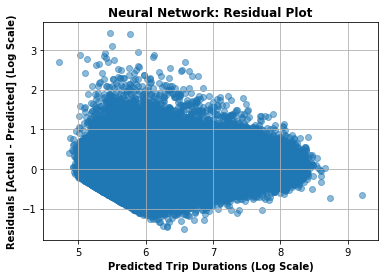

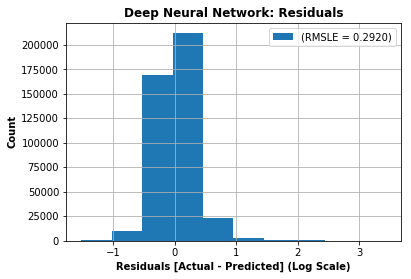

In [34]:
model_name= 'nn'
plt.scatter(validation_df['nn_pred'],
              (validation_df['actual_trip_duration'] - validation_df[model_name + '_pred']),
               alpha=0.5)
plt.title('Neural Network: Residual Plot', color='black', weight='bold')
plt.xlabel('Predicted Trip Durations (Log Scale)', weight='bold')
plt.ylabel('Residuals [Actual - Predicted] (Log Scale)', weight='bold')
plt.grid()
plt.show()

 # Compute validation RMSLE
rmsle = compute_rmse(y_pred=(validation_df[model_name + '_pred']), y_true=(validation_df['actual_trip_duration']))
plt.hist((validation_df['actual_trip_duration'] - validation_df[model_name+'_pred']),
       label='(RMSLE = %0.4f)' % (rmsle))
plt.title('Deep Neural Network: Residuals', color='black', weight='bold')
plt.ylabel('Count', weight='bold')
plt.xlabel('Residuals [Actual - Predicted] (Log Scale)', weight='bold')
plt.legend()
plt.grid()
plt.show()

In [35]:
submit_df = test[['id']]
submit_df['nn_pred'] = submit_preds.flatten().tolist()
submit_df['nn_pred'] = np.exp(submit_df['nn_pred'])
submit_df_Final = submit_df[['id', 'nn_pred']].rename(columns={'nn_pred':'trip_duration'})
submit_df_Final.to_csv('models_with_traffic_feats/NN_Test_submit_200EPOCH_ALL_OSM_FEAT.csv', index=False)

## [4] Kaggle Competition Standings, Conclusion & Future Work

### [4.1] Kaggle Competition Standings

Predictions on the Kaggle submission set using the <b>RandomForest</b> model yeilded a score on Kaggle of <b>0.48861</b>. This corresponds to a rank of 769 on the public leaderboard.

Predictions on the Kaggle submission set using the <b>Deep Neural Net </b> model yeilded a score on Kaggle of <b>0.46228</b>. This corresponds to a rank of 722 on the public leaderboard, improving the rank by nearly 50 positions. 


### [4.2] Conclusion & Future Work

Although we didn't exactly achieve stellar positions on the leaderboard, we have proved that it is possible to build models that perform resonably well at predicting taxi trip durations. We have made a decent start and with some more improvements, it is very likely we achieve better rankings on the leaderboard.

The observation that all models developed underpredict lower values of trip duration leads one to think that perhaps there is some missing information or feature that if added will significantly improve performance. A few possibilities that come to mind are:
- Actual trip distance and number of left/right turns for each trip using some sort of routing software such as Google Maps
- Traffic information: density, number of traffic lights on a route etc.
- More granular weather information: hourly precipitation amounts, snowfall amounts etc.

Computing and adding these features could be natural items for future work on this project in addition to trying other transformations for existing features, dimensionality reduction etc. to see if performance is improved.